# Understaning the Gradient Correlation

April 6, 2022

Notebook is built from previous notebook `rnn-learning/experiments/TCM-2022-4-5/fig2-gradient-2022-4-3.ipynb`

The goal here is to show that different learning rules follow different gradients. We set this up to loosely mirror a BMI-like experiment:

1. Train monkey with BMI $W^{bmi1}$ to proficiency
2. Change decoder to $W^{bmi2}$
3. Train with new decoder

Here I am curious to understand what improves our correlation metric. Is it the amount of pretraining? Is it the relationship between the readout decoder and the internal matrix?



This is a summary slide from my thesis committee meeting on April 5, 2022:

![summary](../TCM-2022-4-5/screenshot-summary-gradient-2022-4-6.png)



## Questions I try to address here

what determines how well aligned our predicted change in flow field will be with the measured change in flow field? Our calculations are linear and so the question might be rephrased as "when are weight updates in the linear (and smooth!) regime? I have a few hunches:

1. The duration of pretraining
2. The amount of training required (i.e. how similar is the new decoder to the old decoder?)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Repeat Analysis for RFLO Multiple Networks/Seeds

Here is where I need to establish that these results are robust. Using the same initialized, pretrained network, I calculate the correlation across 6 random choices of new decoder matrices `w_out1` and internal models `w_m`. As before, I choose a 60% overlap with the old decoder `w_out0`

21it [00:00, 199.58it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fa0cc81c678>


5000it [00:20, 239.75it/s]
101it [00:00, 1006.28it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1186.51it/s]
10it [00:00, 264.89it/s]
500it [00:00, 1223.00it/s]


AR early fit 0.971, late fit 0.971


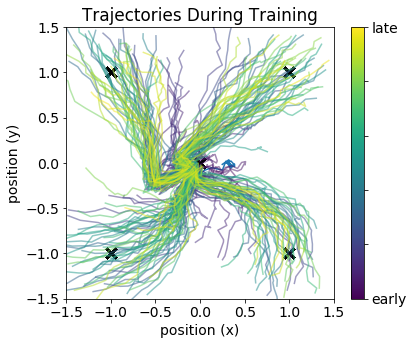

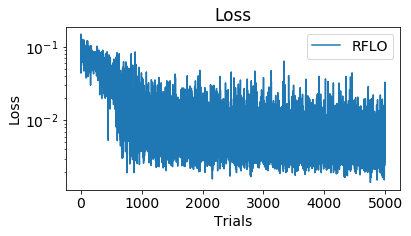

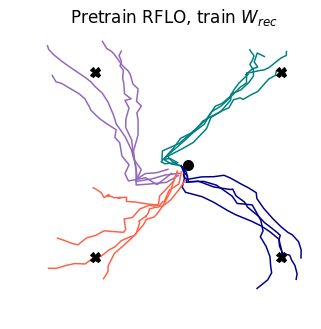

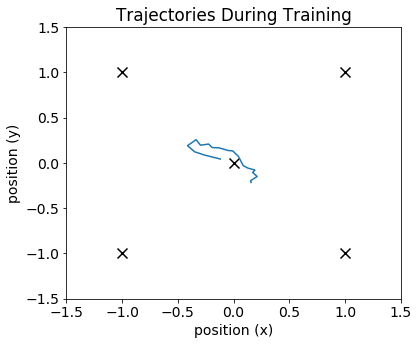

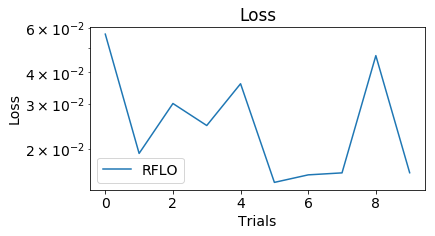

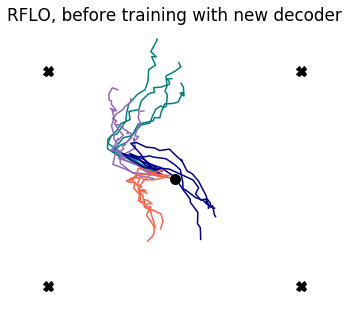

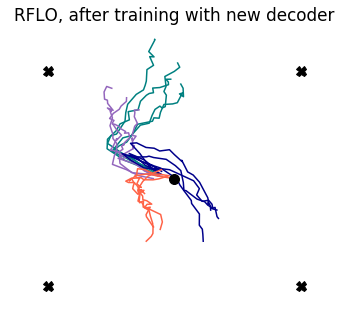

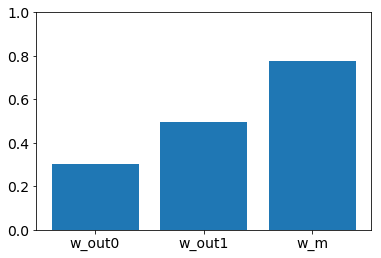

115it [00:00, 1147.34it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 1013.92it/s]
10it [00:00, 251.12it/s]
500it [00:00, 1142.99it/s]


AR early fit 0.971, late fit 0.971


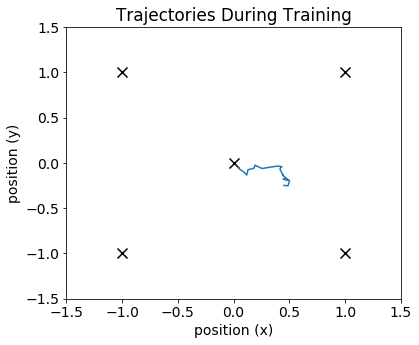

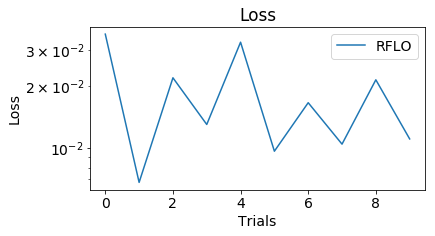

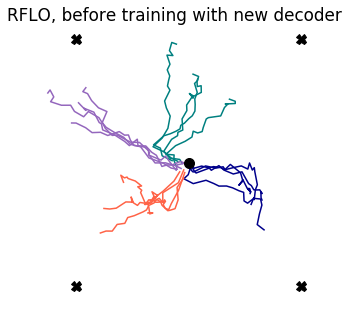

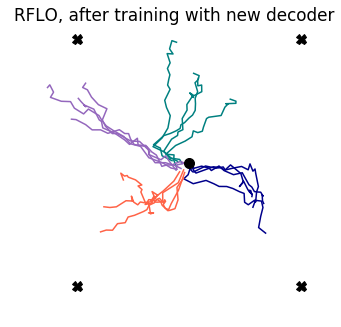

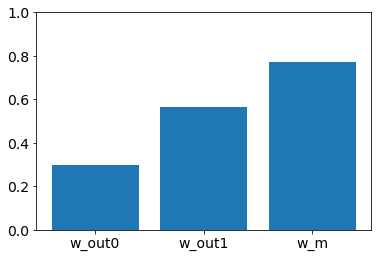

110it [00:00, 1097.26it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 1214.16it/s]
10it [00:00, 215.61it/s]
500it [00:00, 1267.45it/s]


AR early fit 0.971, late fit 0.971


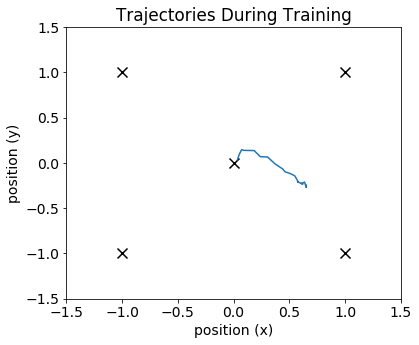

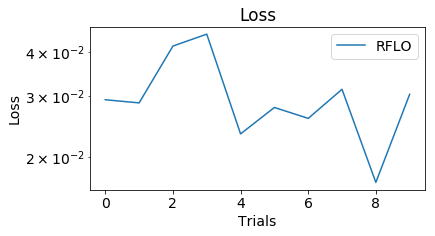

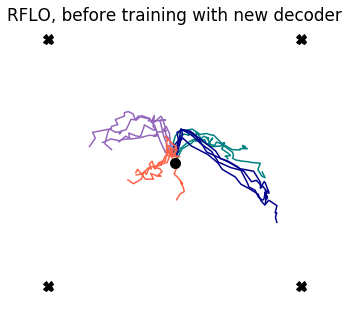

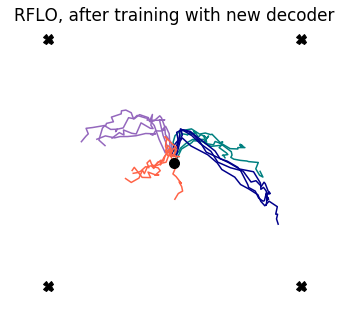

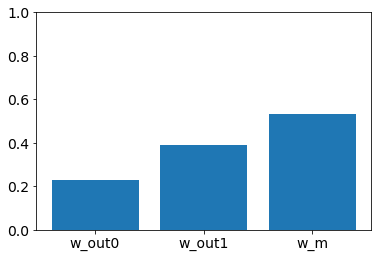

87it [00:00, 867.68it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 1096.67it/s]
10it [00:00, 256.57it/s]
500it [00:00, 1108.79it/s]


AR early fit 0.971, late fit 0.971


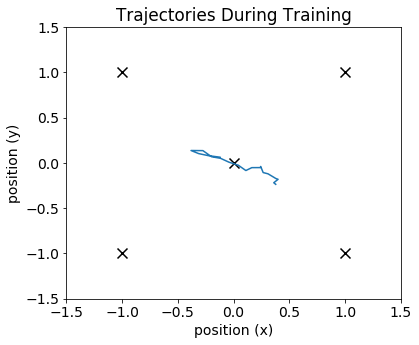

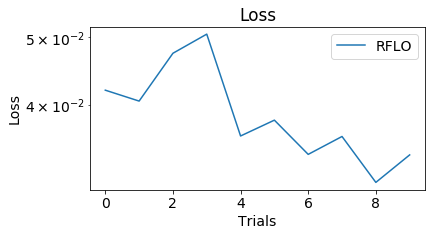

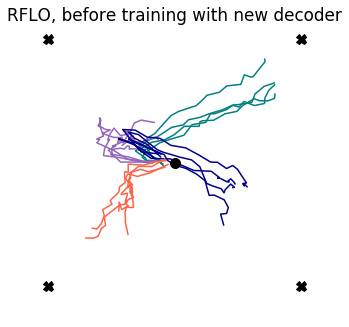

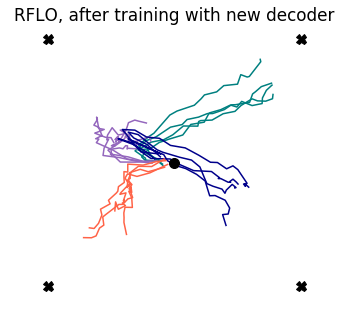

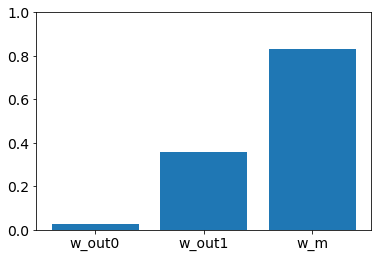

115it [00:00, 1142.92it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 1177.09it/s]
10it [00:00, 262.67it/s]
500it [00:00, 1135.92it/s]


AR early fit 0.971, late fit 0.971


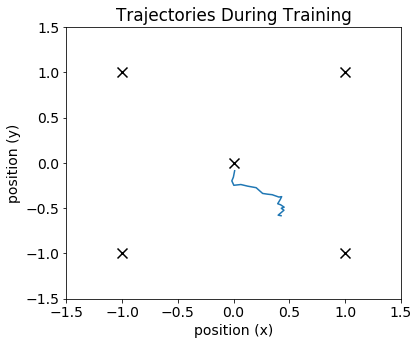

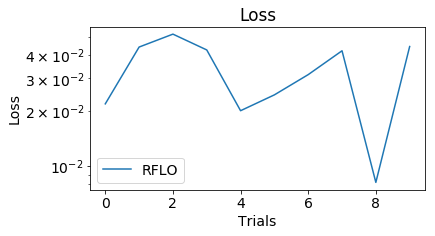

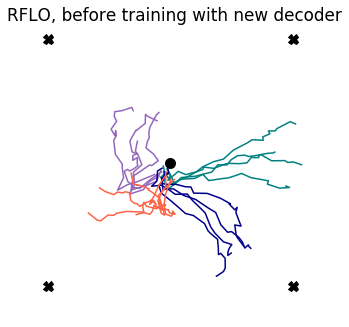

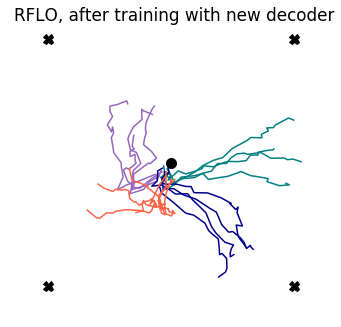

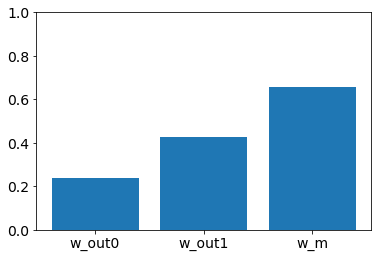

123it [00:00, 1229.94it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1103.18it/s]
50it [00:00, 281.60it/s]
500it [00:00, 1249.83it/s]


AR early fit 0.971, late fit 0.971


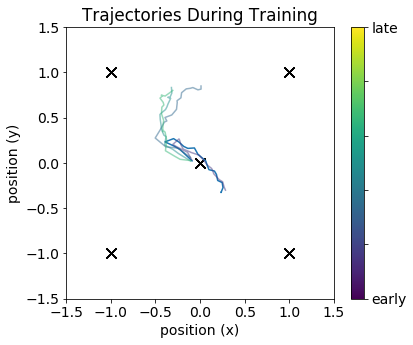

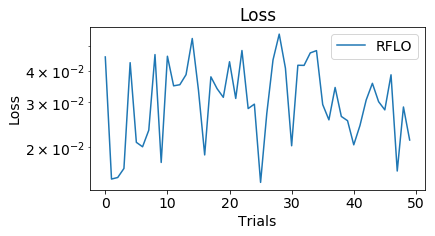

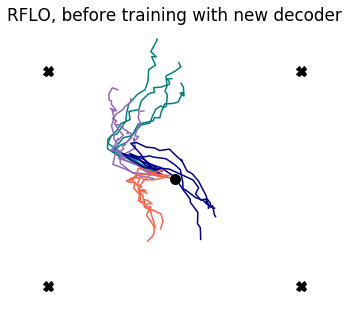

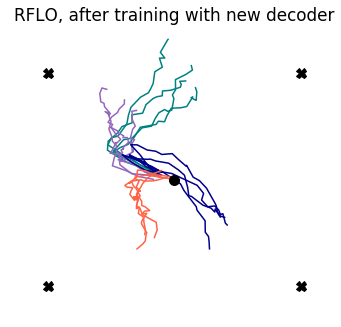

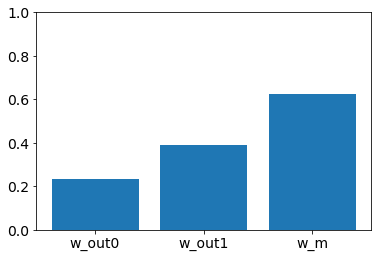

98it [00:00, 976.89it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 1109.02it/s]
50it [00:00, 320.17it/s]
500it [00:00, 1149.22it/s]


AR early fit 0.971, late fit 0.971


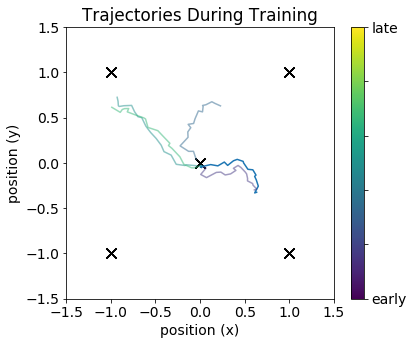

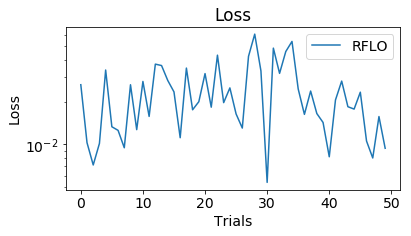

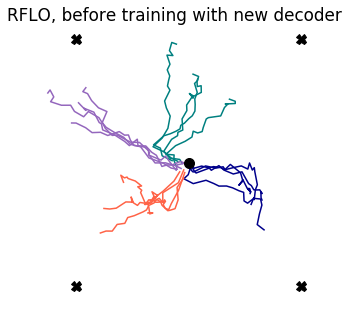

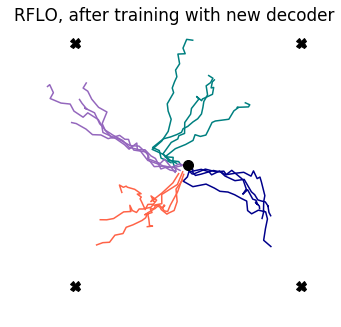

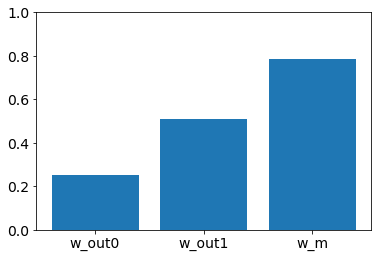

89it [00:00, 884.51it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 1049.57it/s]
50it [00:00, 323.78it/s]
500it [00:00, 1100.24it/s]


AR early fit 0.971, late fit 0.971


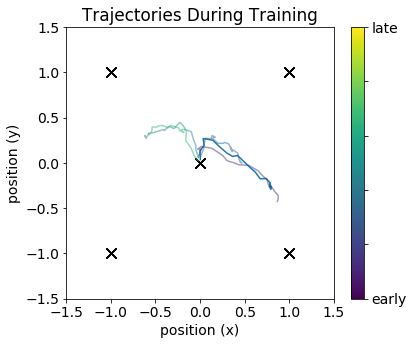

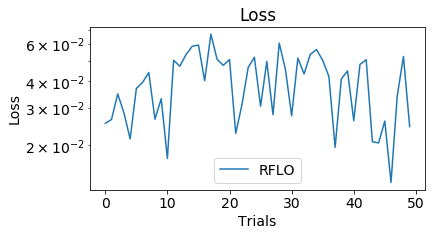

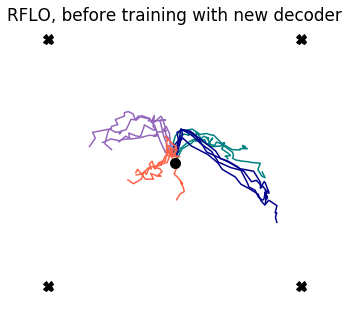

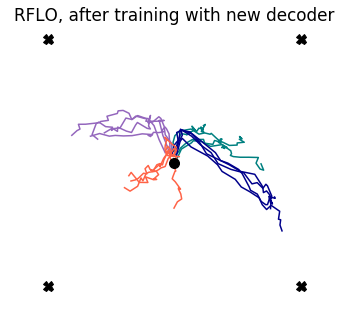

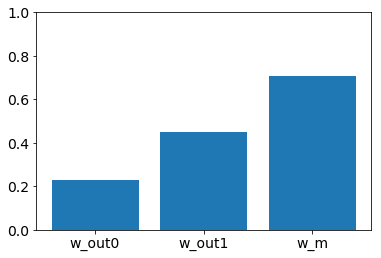

117it [00:00, 1165.00it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 1136.23it/s]
50it [00:00, 328.16it/s]
500it [00:00, 1129.63it/s]


AR early fit 0.971, late fit 0.971


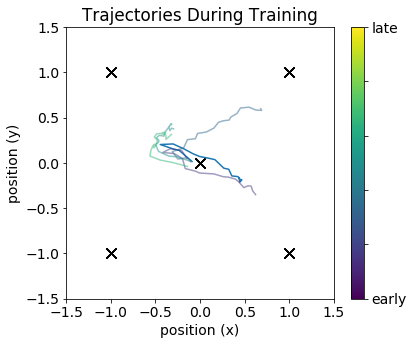

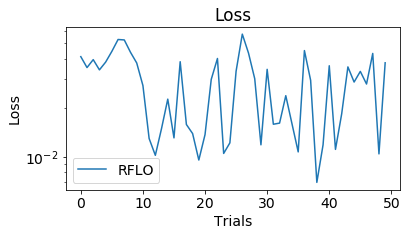

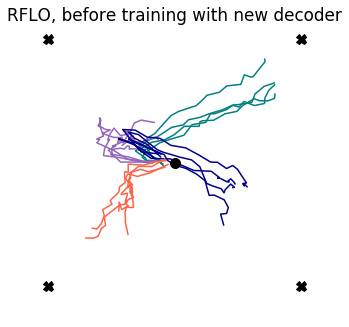

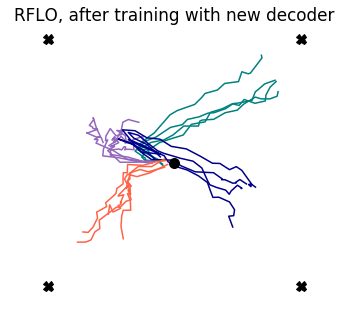

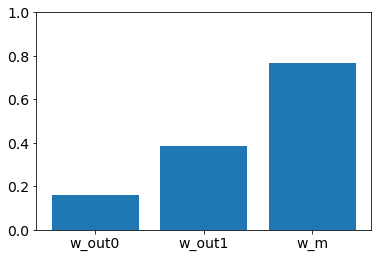

115it [00:00, 1144.73it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 1123.33it/s]
50it [00:00, 218.76it/s]
500it [00:00, 863.16it/s]


AR early fit 0.971, late fit 0.972


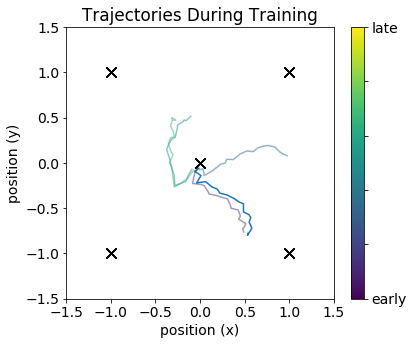

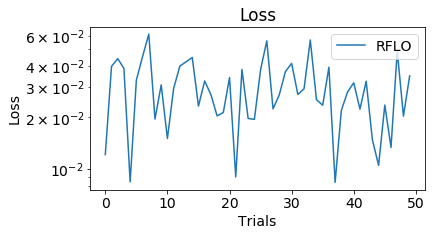

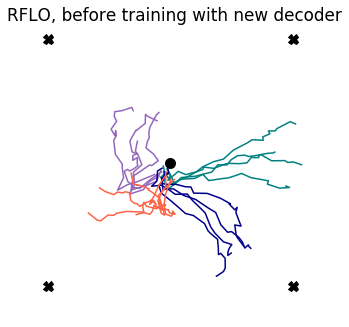

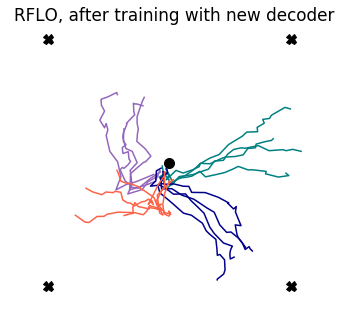

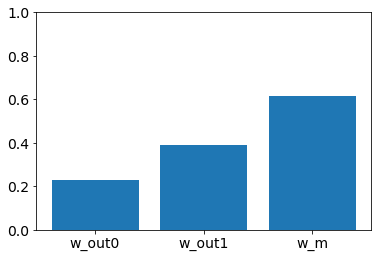

125it [00:00, 1247.95it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1115.62it/s]
100it [00:00, 366.65it/s]
500it [00:00, 1204.91it/s]


AR early fit 0.971, late fit 0.971


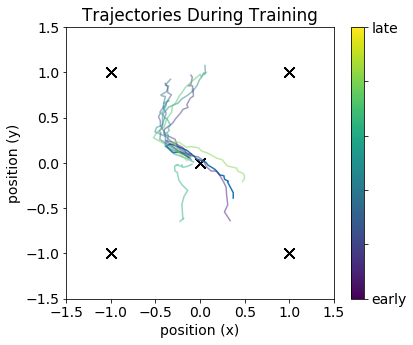

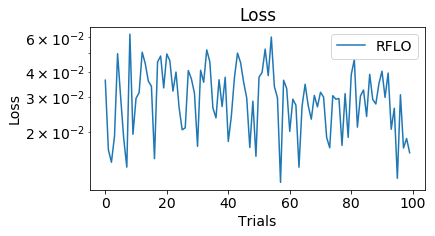

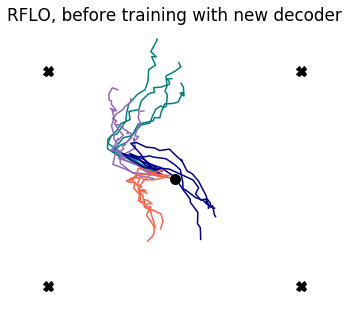

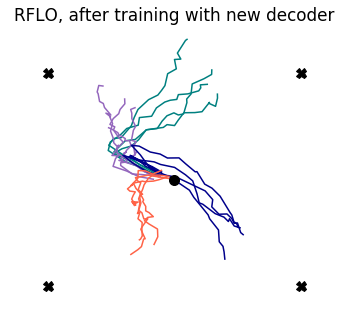

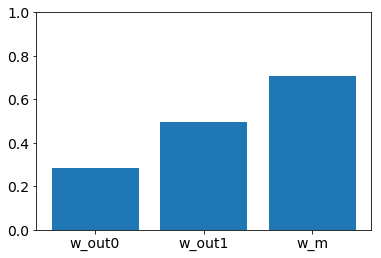

105it [00:00, 1048.53it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 1125.10it/s]
100it [00:00, 267.73it/s]
500it [00:00, 1068.18it/s]


AR early fit 0.971, late fit 0.972


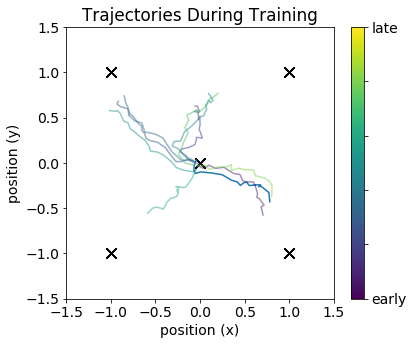

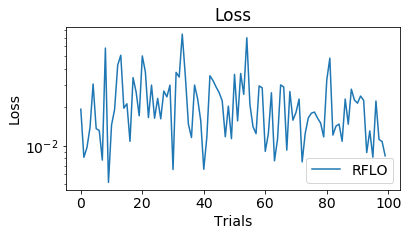

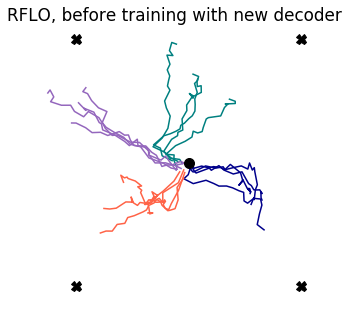

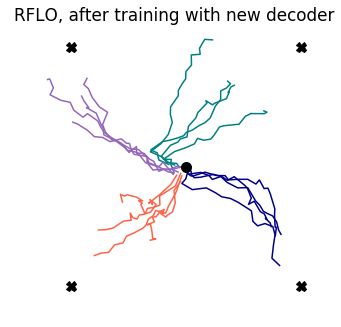

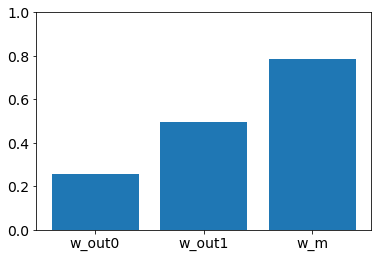

105it [00:00, 1049.11it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 1142.94it/s]
100it [00:00, 353.03it/s]
500it [00:00, 1133.94it/s]


AR early fit 0.971, late fit 0.972


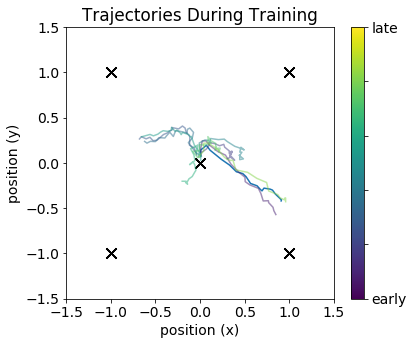

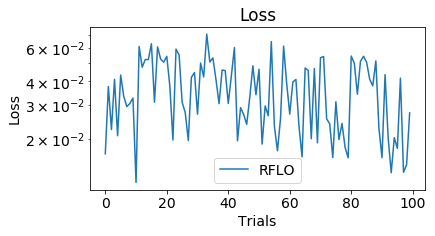

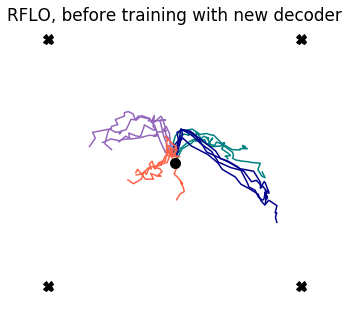

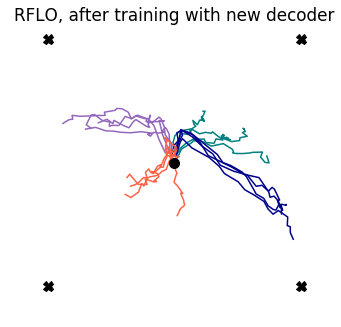

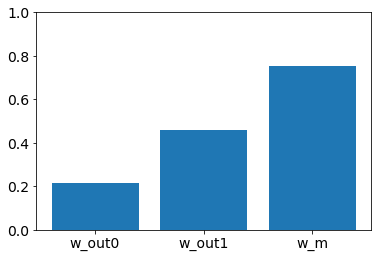

104it [00:00, 1034.29it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 1224.05it/s]
100it [00:00, 368.75it/s]
500it [00:00, 963.93it/s]


AR early fit 0.971, late fit 0.972


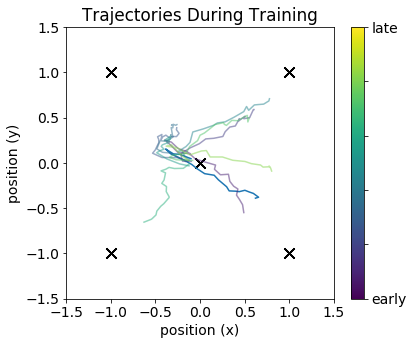

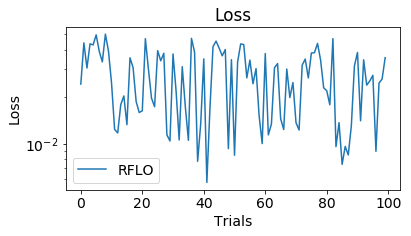

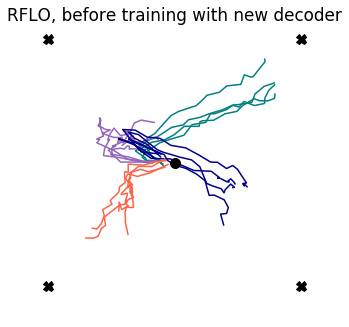

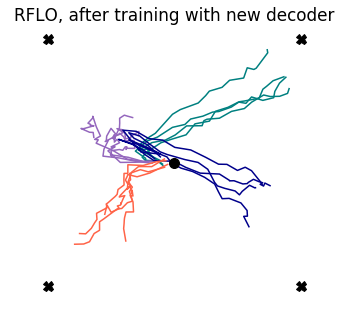

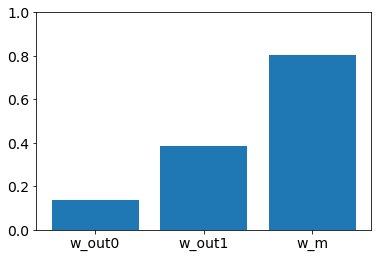

105it [00:00, 1044.24it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 1017.48it/s]
100it [00:00, 246.79it/s]
500it [00:01, 419.55it/s]


AR early fit 0.971, late fit 0.973


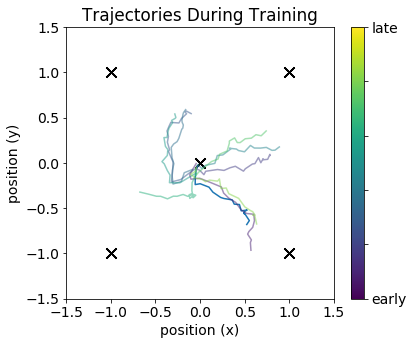

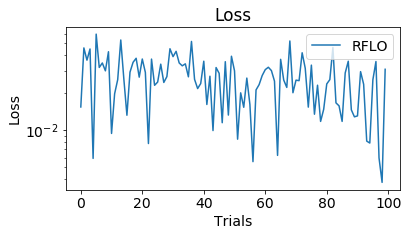

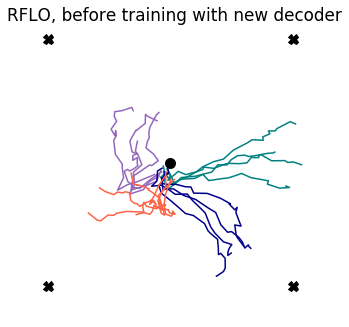

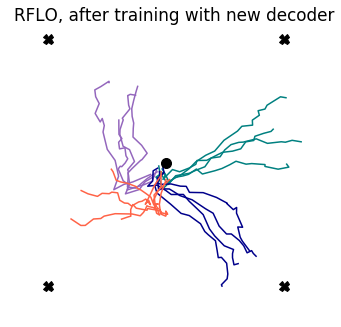

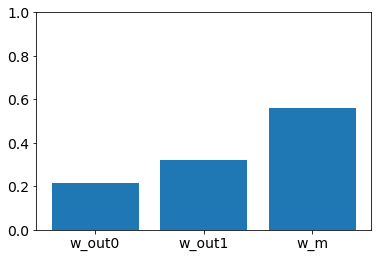

137it [00:00, 1365.60it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1311.78it/s]
500it [00:01, 427.66it/s]
500it [00:00, 1309.66it/s]


AR early fit 0.971, late fit 0.975


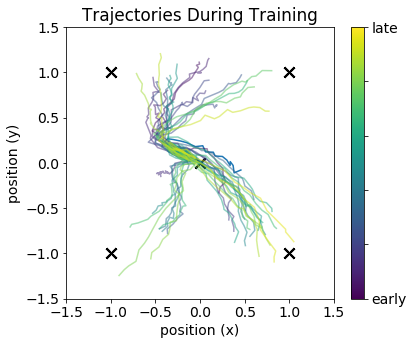

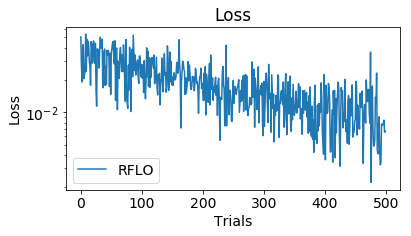

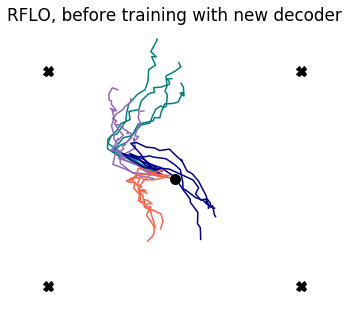

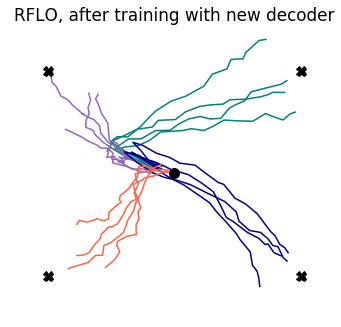

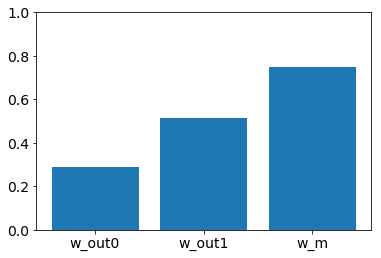

93it [00:00, 926.92it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 873.76it/s]
500it [00:01, 368.61it/s]
500it [00:00, 881.63it/s]


AR early fit 0.971, late fit 0.976


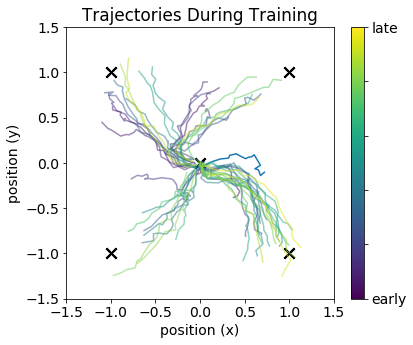

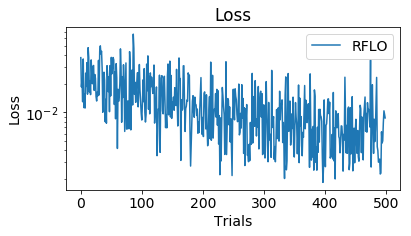

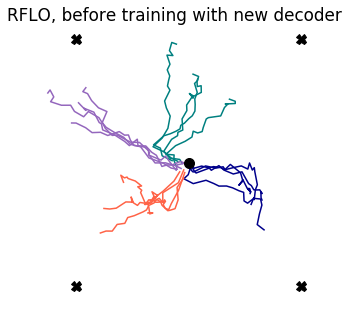

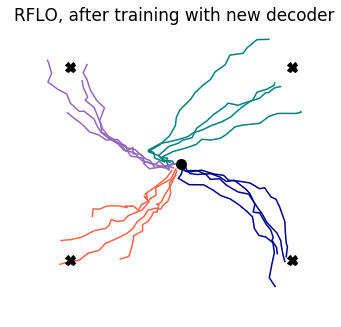

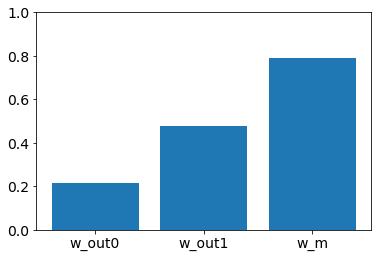

28it [00:00, 279.38it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 1035.34it/s]
500it [00:01, 390.58it/s]
500it [00:00, 855.77it/s]


AR early fit 0.971, late fit 0.977


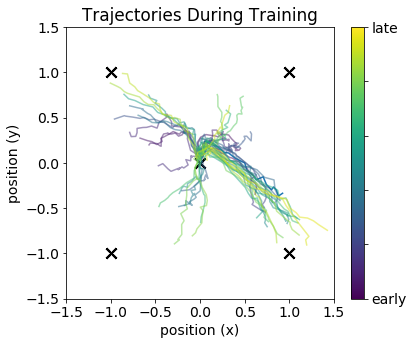

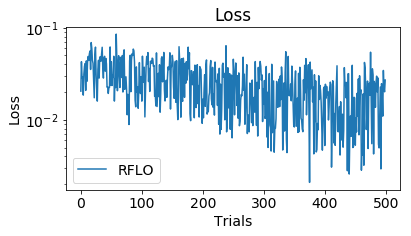

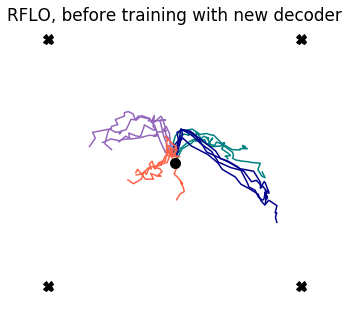

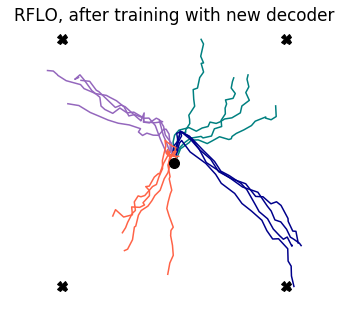

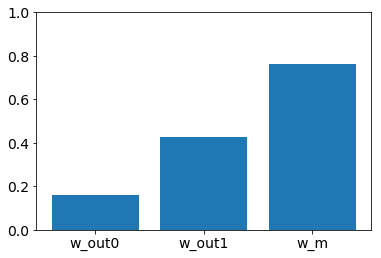

95it [00:00, 945.16it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 1131.75it/s]
500it [00:01, 373.93it/s]
500it [00:00, 750.82it/s]


AR early fit 0.971, late fit 0.976


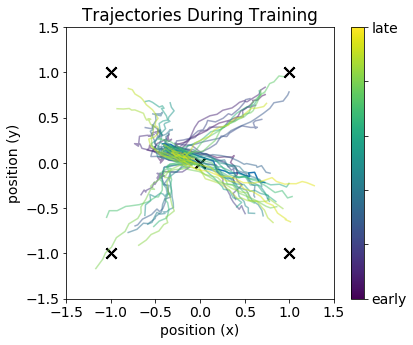

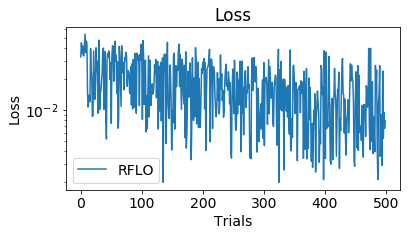

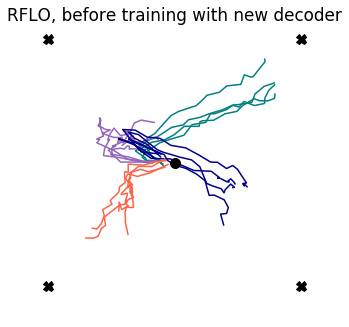

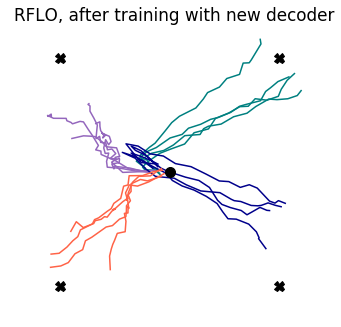

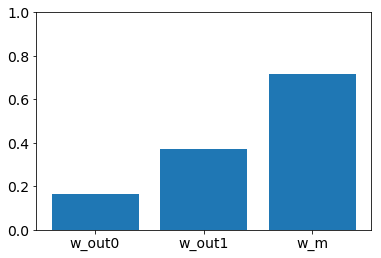

117it [00:00, 1163.34it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 1206.55it/s]
500it [00:01, 396.86it/s]
500it [00:00, 1248.17it/s]


AR early fit 0.971, late fit 0.978


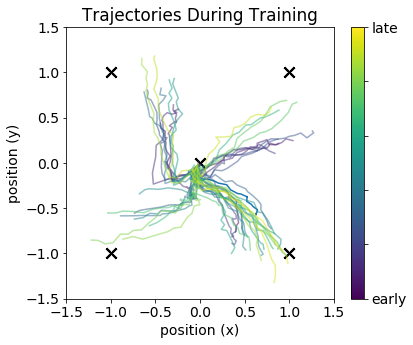

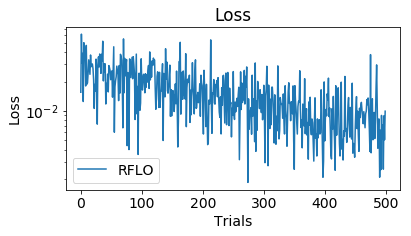

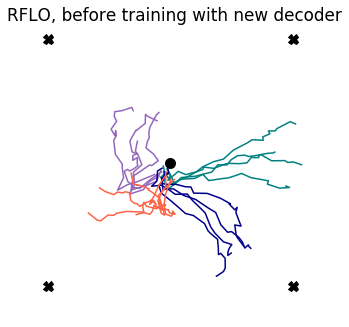

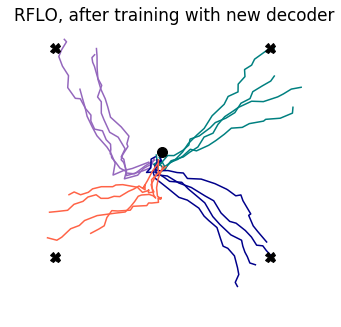

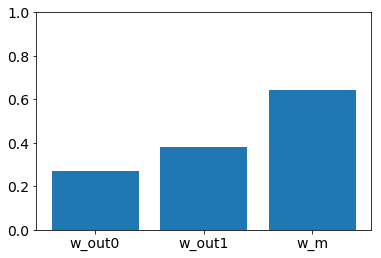

124it [00:00, 1235.31it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1214.26it/s]
1000it [00:02, 398.91it/s]
500it [00:00, 1257.06it/s]


AR early fit 0.971, late fit 0.978


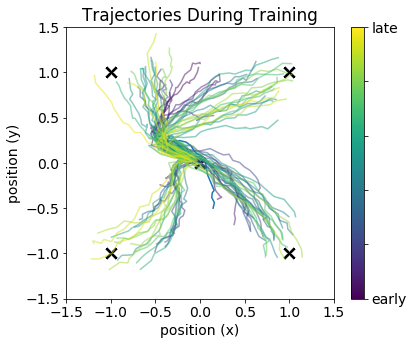

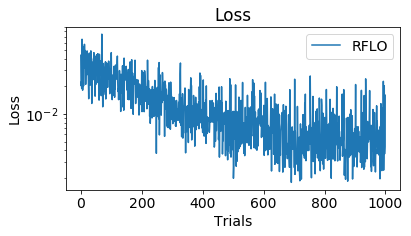

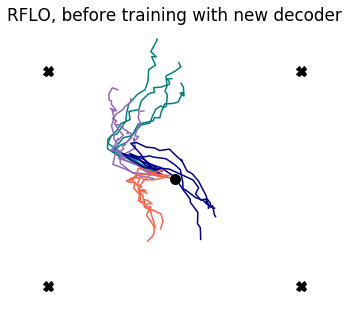

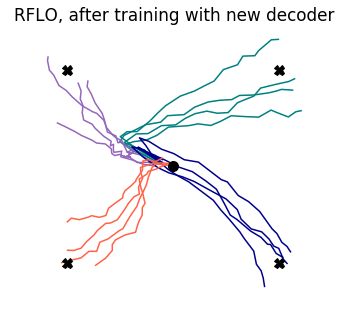

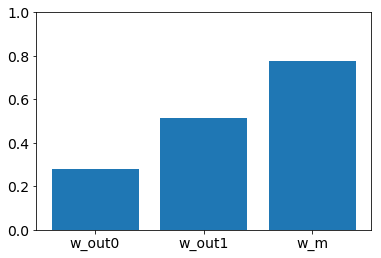

97it [00:00, 969.83it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 1181.97it/s]
1000it [00:02, 381.87it/s]
500it [00:00, 1268.00it/s]


AR early fit 0.971, late fit 0.979


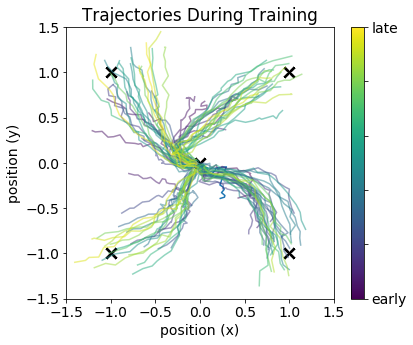

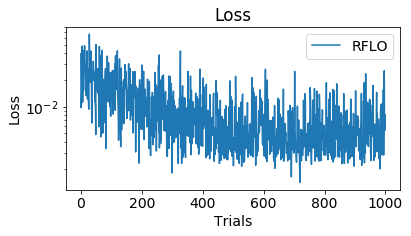

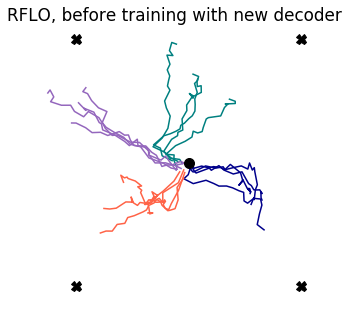

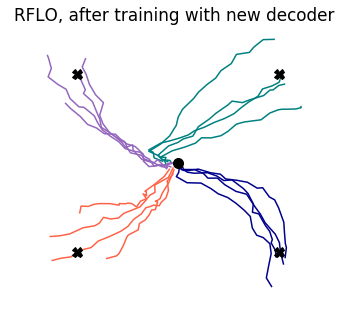

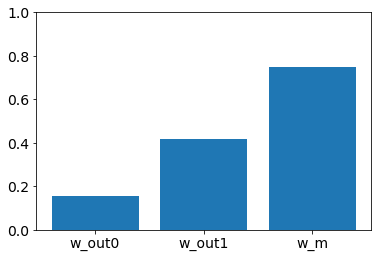

123it [00:00, 1225.33it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 1245.71it/s]
1000it [00:02, 359.80it/s]
500it [00:00, 1244.76it/s]


AR early fit 0.971, late fit 0.981


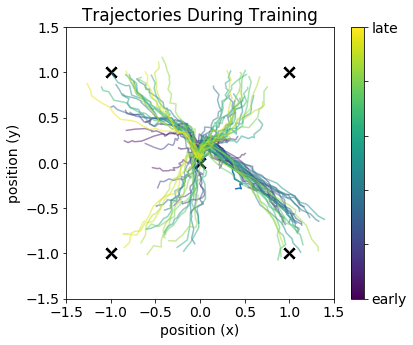

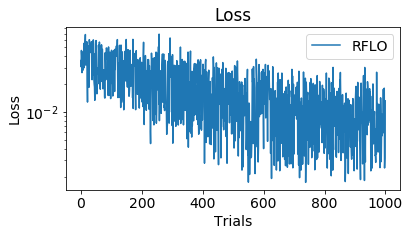

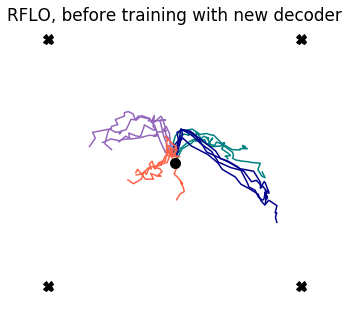

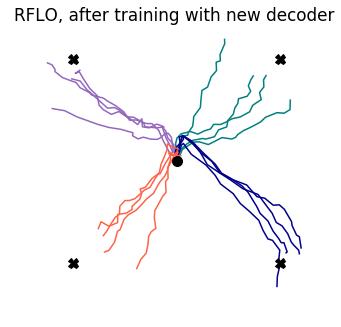

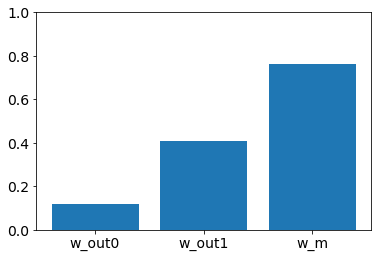

115it [00:00, 1145.86it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 1199.78it/s]
1000it [00:02, 398.45it/s]
500it [00:00, 897.77it/s]


AR early fit 0.971, late fit 0.979


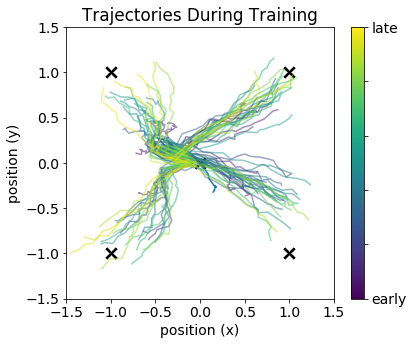

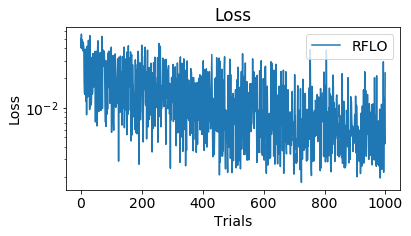

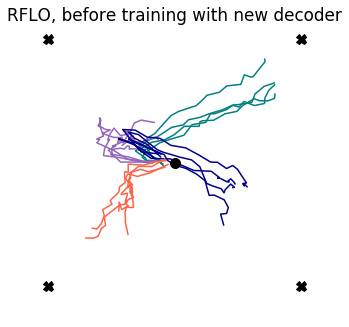

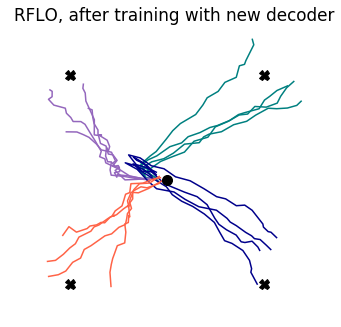

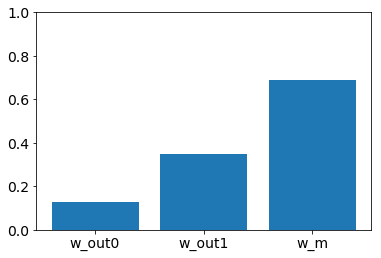

50it [00:00, 494.92it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 957.57it/s]
1000it [00:03, 267.79it/s]
500it [00:00, 1059.17it/s]


AR early fit 0.971, late fit 0.981


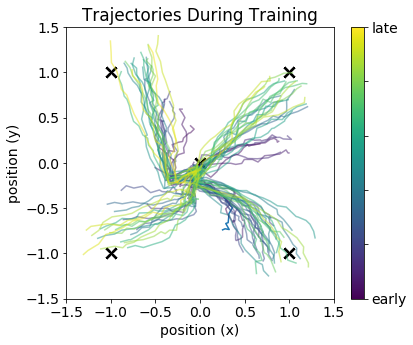

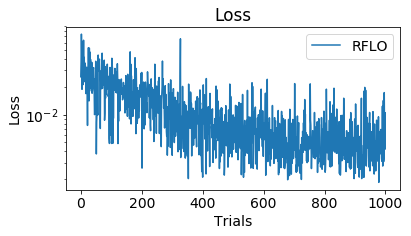

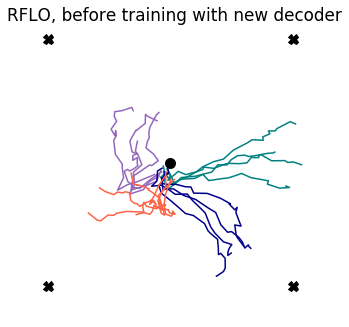

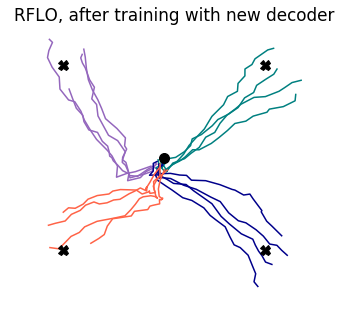

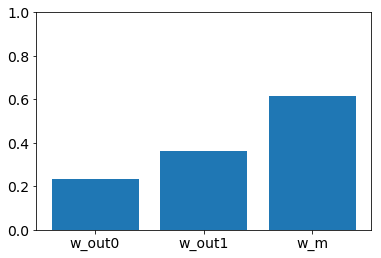

124it [00:00, 1238.07it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 1126.66it/s]
2000it [00:05, 355.82it/s]
500it [00:00, 881.18it/s]


AR early fit 0.971, late fit 0.981


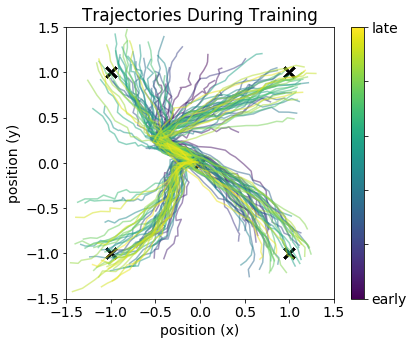

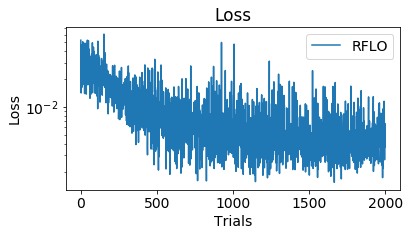

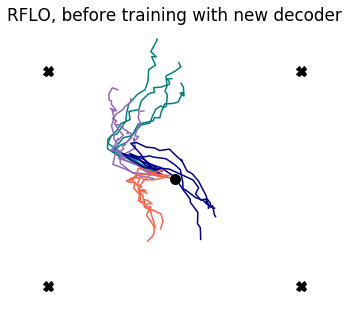

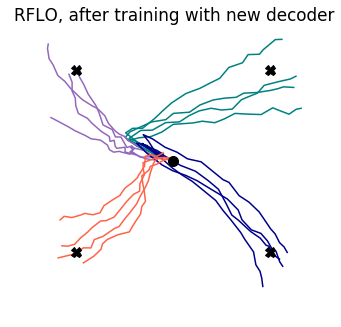

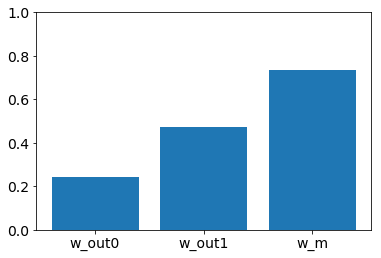

107it [00:00, 1067.31it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 1130.59it/s]
2000it [00:05, 347.95it/s]
500it [00:00, 1178.62it/s]


AR early fit 0.971, late fit 0.981


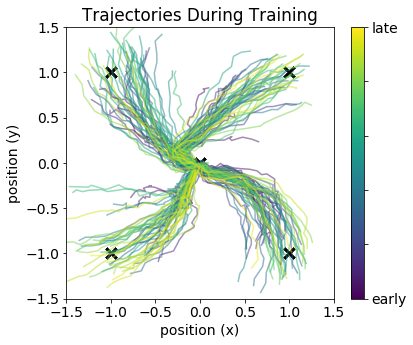

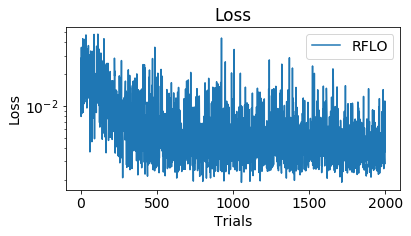

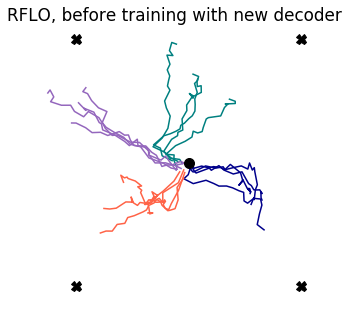

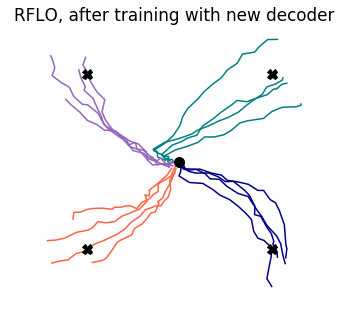

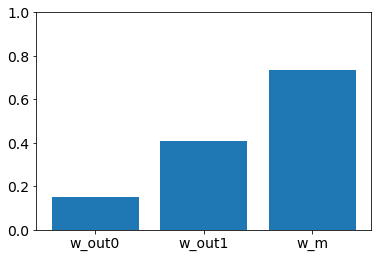

83it [00:00, 824.02it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 904.29it/s]
2000it [00:07, 260.78it/s]
500it [00:00, 867.03it/s]


AR early fit 0.971, late fit 0.984


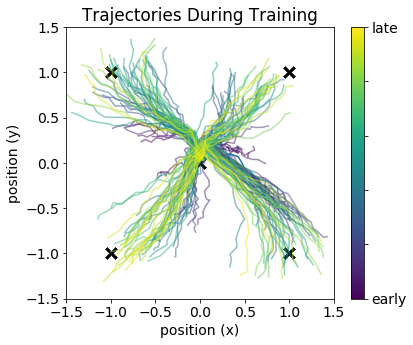

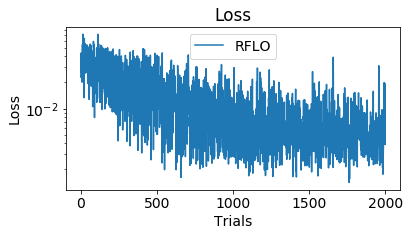

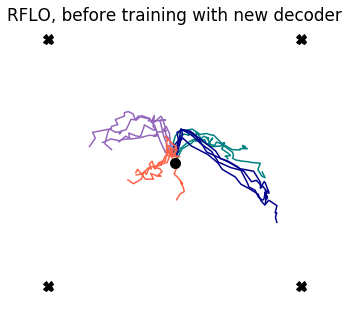

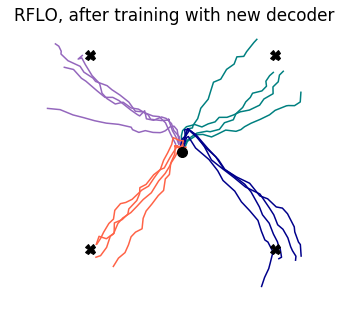

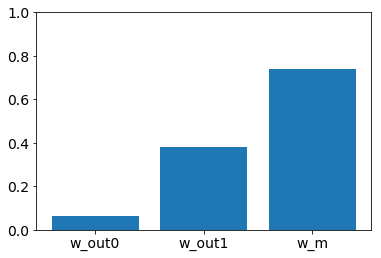

71it [00:00, 695.95it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 820.34it/s]
2000it [00:07, 283.69it/s]
500it [00:00, 924.66it/s]


AR early fit 0.971, late fit 0.982


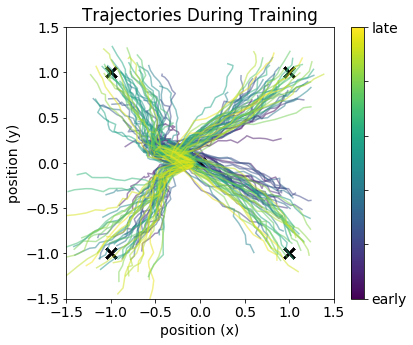

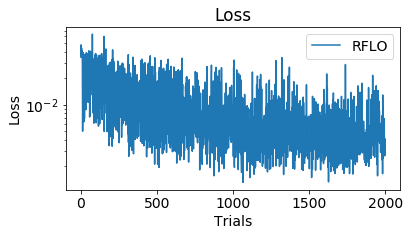

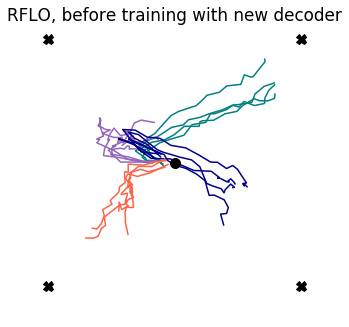

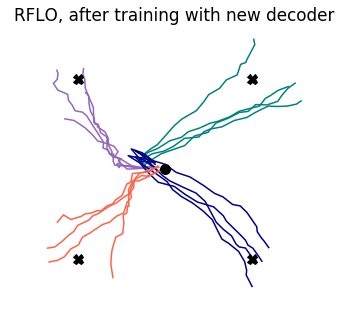

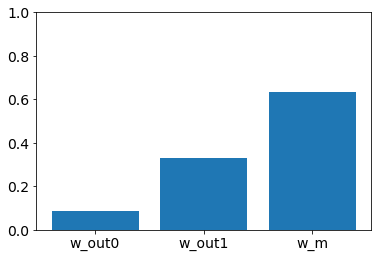

94it [00:00, 934.11it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 943.67it/s]
2000it [00:06, 288.51it/s]
500it [00:00, 936.07it/s]


AR early fit 0.971, late fit 0.983


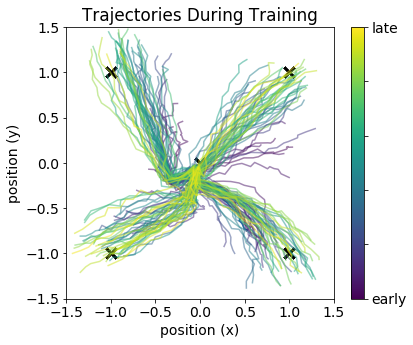

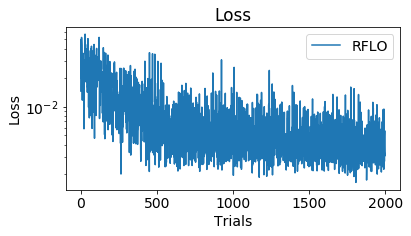

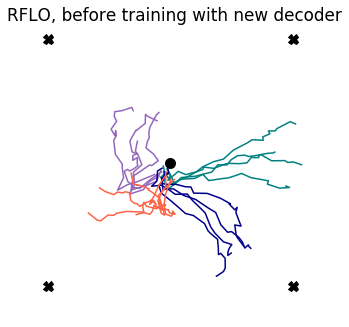

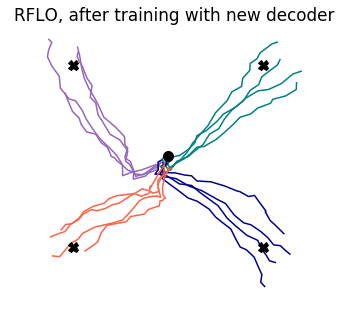

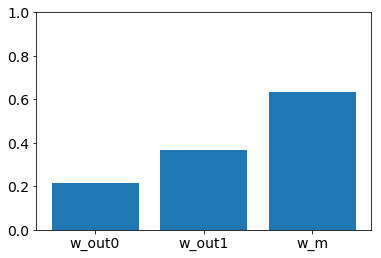

93it [00:00, 924.79it/s]

M norm: 1.08	 M angle: 0.60, 1 iterations
w_out1 norm: 1.39	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.08	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.57	 w_out vs. w_m angle: 0.45

500it [00:00, 956.76it/s]
5000it [00:19, 253.39it/s]
500it [00:00, 545.87it/s]


AR early fit 0.971, late fit 0.983


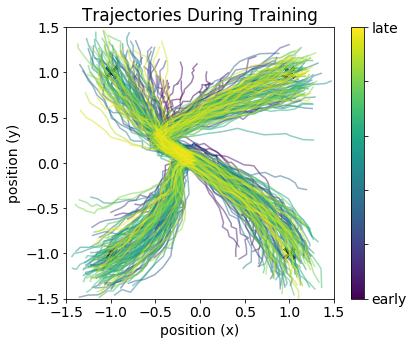

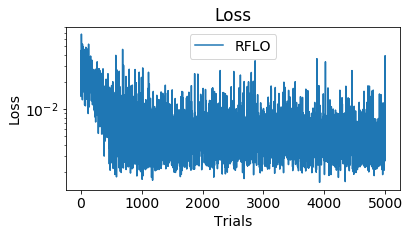

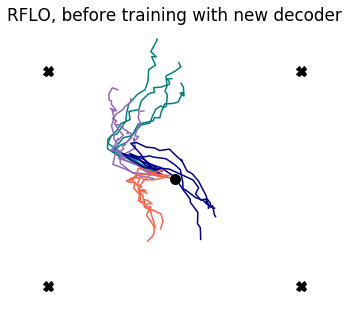

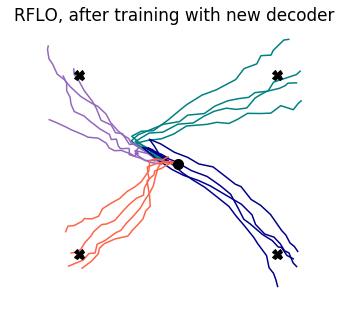

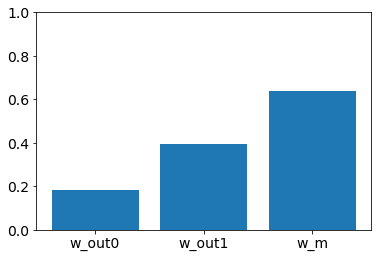

73it [00:00, 725.26it/s]

M norm: 1.15	 M angle: 0.59, 9 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.15	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.68	 w_out vs. w_m angle: 0.34

500it [00:00, 926.18it/s]
5000it [00:20, 248.39it/s]
500it [00:00, 947.22it/s]


AR early fit 0.971, late fit 0.983


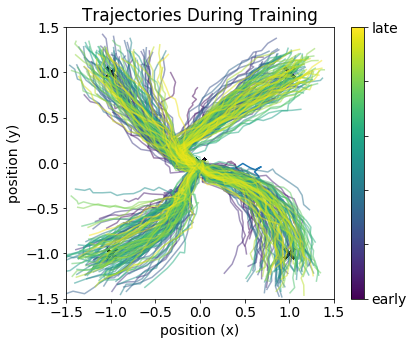

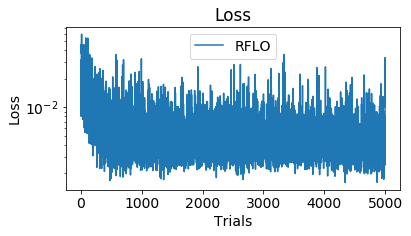

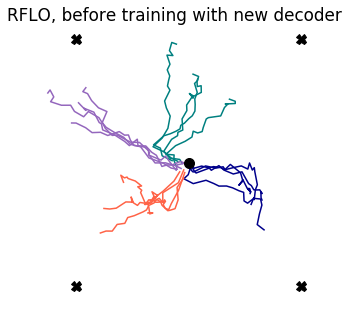

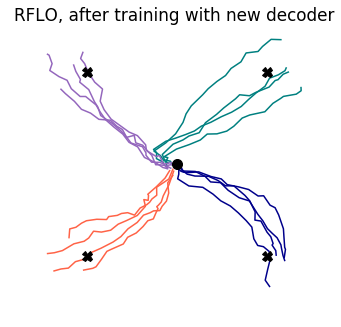

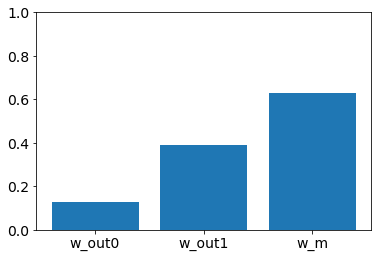

85it [00:00, 844.26it/s]

M norm: 1.04	 M angle: 0.60, 6 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.04	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.32

500it [00:00, 898.23it/s]
5000it [00:19, 254.20it/s]
500it [00:00, 932.37it/s]


AR early fit 0.971, late fit 0.988


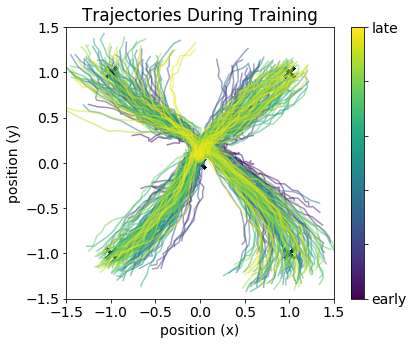

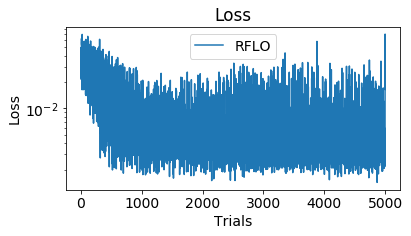

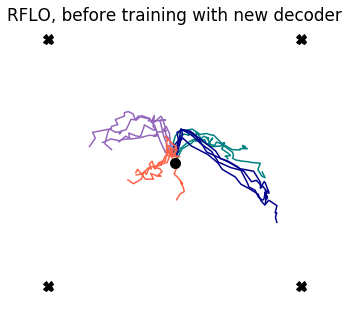

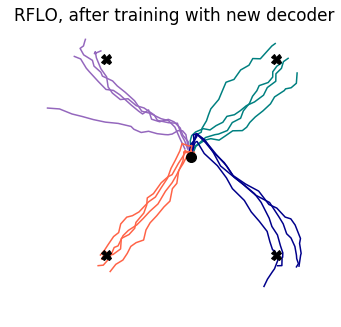

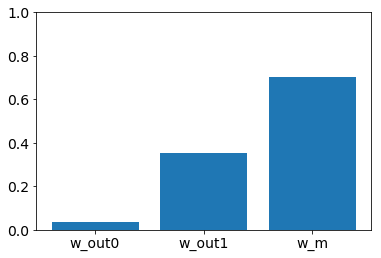

93it [00:00, 926.82it/s]

M norm: 1.13	 M angle: 0.60, 22 iterations
w_out1 norm: 1.41	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:00, 941.82it/s]
5000it [00:19, 253.41it/s]
500it [00:00, 984.63it/s]


AR early fit 0.971, late fit 0.985


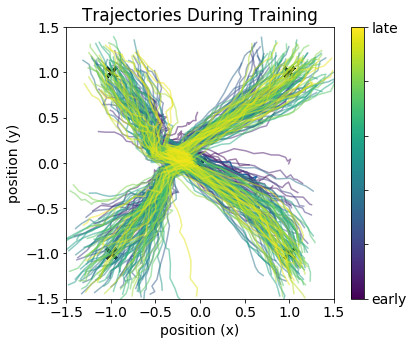

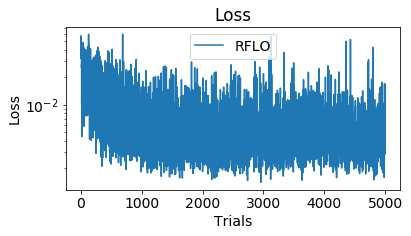

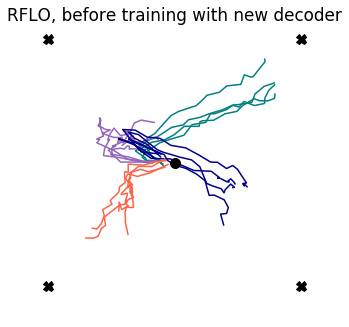

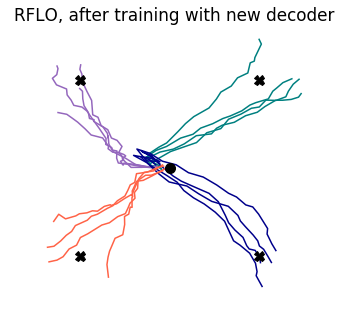

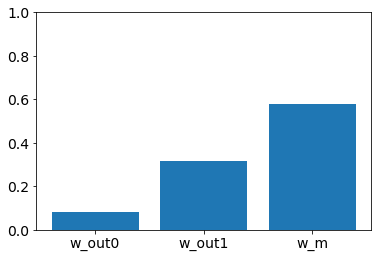

82it [00:00, 813.13it/s]

M norm: 1.11	 M angle: 0.60, 3 iterations
w_out1 norm: 1.40	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.70	 w_out vs. w_m angle: 0.35

500it [00:00, 959.99it/s]
5000it [00:21, 237.45it/s]
500it [00:00, 1014.75it/s]


AR early fit 0.971, late fit 0.986


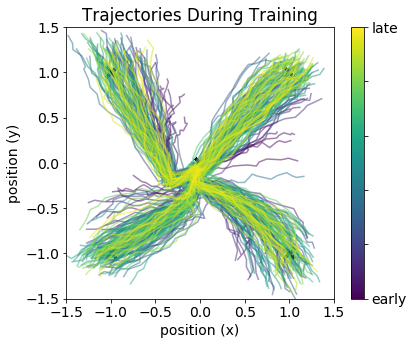

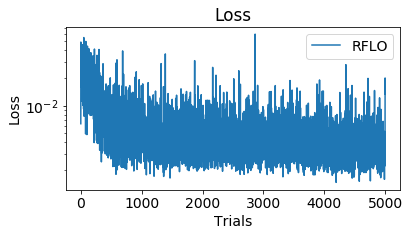

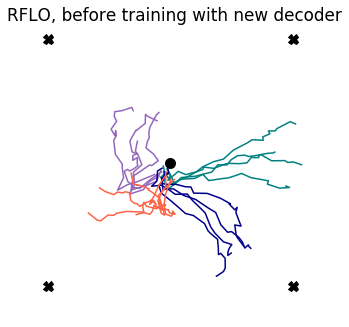

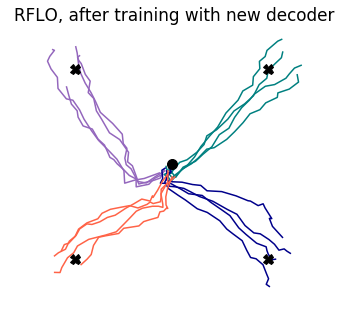

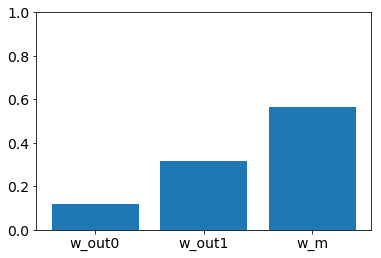

In [7]:
init = 1981

results = {}

#pretraining = [10,50,100,500,1000,2000,5000]
#for pretrain_duration in pretraining:

pretrain_duration = 5000

# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(init))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')



training = [10,50,100,500,1000,2000,5000]
for train_duration in training:

    #results[str(pretrain_duration)] = {}
    results[str(train_duration)] = {}


    """ Average over multiple seeds """
    seeds = [0,1,2,3,5]
    overlaps = [0.6]
    n_changes = [50]

    stats = {}
    stats['corr1'] = []
    stats['corr2'] = []
    stats['corr3'] = []
    stats['corrcoef'] = []

    for seed in seeds:

        corr1_list = []
        corr2_list = []
        corr3_list = []
        corrcoef_list = []

        for overlap,n_change in zip(overlaps,n_changes):

            """ Choose new decoder and internal matrix """
            w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
            w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

            # confirm overlap between w_out1 and w_out
            norm, angle = return_norm_and_angle(net0.w_out,w_out1)
            print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

            # confirm overlap between w_out1 and w_m
            norm, angle = return_norm_and_angle(w_out1,w_m)
            print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

            # confirm overlap between w_out and w_m
            norm, angle = return_norm_and_angle(net0.w_out,w_m)
            print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')




            net1_pre = RNN(params)
            net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
            net1_pre.set_weights(w_out = w_out1)
            net1_pre.set_weights(w_m = w_m.T)

            # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
            net1 = RNN(params)
            net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
            net1.set_weights(w_out = w_out1)
            net1.set_weights(w_m = w_m.T)




            """ Track activity with new decoder, before training """

            sim1_pre = Simulation(net1_pre)
            trackvars = TrackVars(net1_pre,apply_to=[]) 
            sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
            #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            """ Train with new decoder """

            sim1_train = Simulation(net1)
            rflo = RFLO(net1,apply_to=['w_rec'],online=False)
            sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

            """ Track activity with new decoder, after training """
            net1_post = RNN(params)
            net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
            net1_post.set_weights(w_out = net1.w_out)
            net1_post.set_weights(w_m = net1.w_m)

            sim1_post = Simulation(net1_post)
            trackvars = TrackVars(net1_post,apply_to=[]) 
            sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)


            fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')


            """ Calculate F fields """
            F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
            F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

            print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

            Fdata = F_late - F_early

            # separate train and test data from sim1_train
            n_total = len(sim1_train.session_probes['h'])
            n_train = int(0.5 * n_total)
            idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
            idx_test = np.arange(0,n_total)[~idx_train].astype(int)
            #idx_test=idx_train

            h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
            err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

            Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
            Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
            Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

            h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

            corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
            corr1_list.append(corr1)

            corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
            corr2_list.append(corr2)

            corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
            corr3_list.append(corr3)

            fig,ax = plt.subplots(1,1)
            plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'])
            plt.ylim([0,1])
            plt.show()

        # update
        stats['corr1'].append(corr1_list)
        stats['corr2'].append(corr2_list)
        stats['corr3'].append(corr3_list)
        #stats['corrcoef'].append(corrcoef_list)
        
        
    results[str(pretrain_duration)] = stats
    results[str(train_duration)] = stats


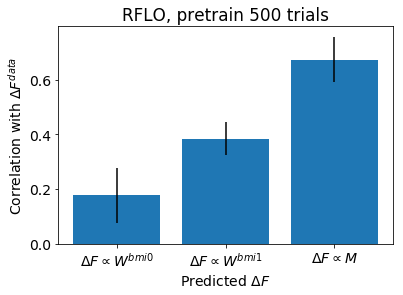

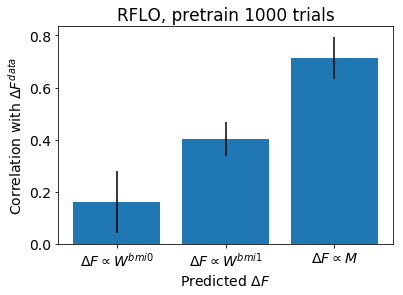

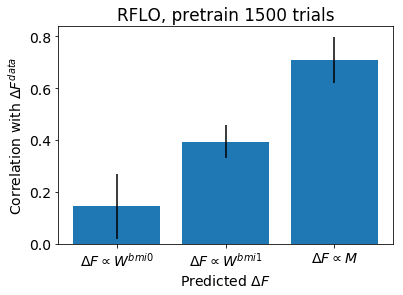

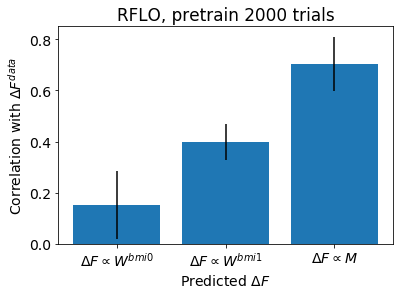

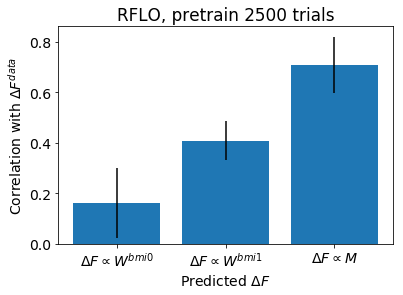

In [9]:

for pretrain_duration in pretraining:
    
    stats = pretrain_results[str(pretrain_duration)]

    """ take mean and std """
    mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
    mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
    mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
    std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
    std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
    std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

    plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta F \propto W^{bmi0}$',r'$\Delta F \propto W^{bmi1}$',r'$\Delta F \propto M$'],color='C0')

    plt.title('RFLO, pretrain {} trials'.format(pretrain_duration))
    plt.ylabel('Correlation with '+r'$\Delta F^{data}$')
    plt.xlabel('Predicted '+r'$\Delta F$')

    plt.show()

# Plot Variation in Pretraining

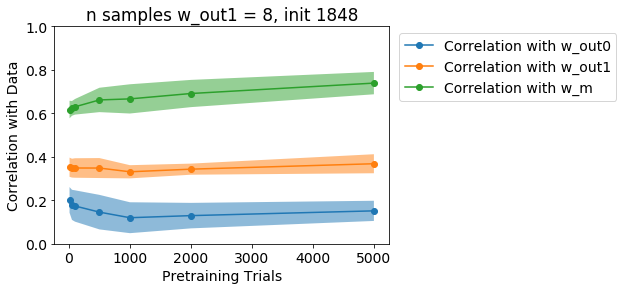

In [5]:

y1 = []
y1_std = []
y2 = []
y2_std = []
y3 = []
y3_std = []
for pretrain_duration in pretraining:
    
    stats = results[str(pretrain_duration)]

    """ take mean and std """
    n = np.asarray(stats['corr2']).shape[0]
    y1.append(np.mean(np.asarray(stats['corr1']),axis=0)[0])
    y1_std.append(np.std(np.asarray(stats['corr1']),axis=0)[0])
    y2.append(np.mean(np.asarray(stats['corr2']),axis=0)[0])
    y2_std.append(np.std(np.asarray(stats['corr2']),axis=0)[0])
    y3.append(np.mean(np.asarray(stats['corr3']),axis=0)[0])
    y3_std.append(np.std(np.asarray(stats['corr3']),axis=0)[0])
    
y1 = np.asarray(y1)
y1_std = np.asarray(y1_std)
y2 = np.asarray(y2)
y2_std = np.asarray(y2_std)
y3 = np.asarray(y3)
y3_std = np.asarray(y3_std)
    
plt.plot(pretraining, y1,'o-',label='Correlation with w_out0')
plt.fill_between(pretraining, y1-y1_std,y1+y1_std,alpha=0.5)

plt.plot(pretraining, y2,'o-',label='Correlation with w_out1')
plt.fill_between(pretraining, y2-y2_std,y2+y2_std,alpha=0.5)

plt.plot(pretraining, y3,'o-',label='Correlation with w_m')
plt.fill_between(pretraining, y3-y3_std,y3+y3_std,alpha=0.5)

plt.ylim([0,1])
plt.xlabel('Pretraining Trials')
plt.ylabel('Correlation with Data')
plt.title('n samples w_out1 = {}, init {}'.format(n,init))
plt.legend(bbox_to_anchor=(1.7,1))
plt.show()

# Plot Variation in Training Duration

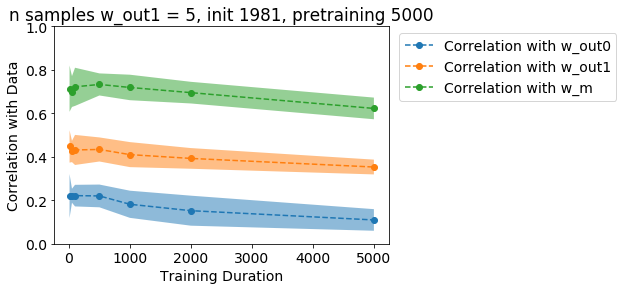

In [8]:

y1 = []
y1_std = []
y2 = []
y2_std = []
y3 = []
y3_std = []

for train_duration in training:
    
    stats = results[str(train_duration)]

    """ take mean and std """
    n = np.asarray(stats['corr2']).shape[0]
    y1.append(np.mean(np.asarray(stats['corr1']),axis=0)[0])
    y1_std.append(np.std(np.asarray(stats['corr1']),axis=0)[0])
    y2.append(np.mean(np.asarray(stats['corr2']),axis=0)[0])
    y2_std.append(np.std(np.asarray(stats['corr2']),axis=0)[0])
    y3.append(np.mean(np.asarray(stats['corr3']),axis=0)[0])
    y3_std.append(np.std(np.asarray(stats['corr3']),axis=0)[0])
    
y1 = np.asarray(y1)
y1_std = np.asarray(y1_std)
y2 = np.asarray(y2)
y2_std = np.asarray(y2_std)
y3 = np.asarray(y3)
y3_std = np.asarray(y3_std)
    
plt.plot(training, y1,'o--',label='Correlation with w_out0')
plt.fill_between(training, y1-y1_std,y1+y1_std,alpha=0.5)

plt.plot(training, y2,'o--',label='Correlation with w_out1')
plt.fill_between(training, y2-y2_std,y2+y2_std,alpha=0.5)

plt.plot(training, y3,'o--',label='Correlation with w_m')
plt.fill_between(training, y3-y3_std,y3+y3_std,alpha=0.5)

plt.ylim([0,1])
plt.xlabel('Training Duration')
plt.ylabel('Correlation with Data')
plt.title('n samples w_out1 = {}, init {}, pretraining {}'.format(n,init,pretrain_duration))
plt.legend(bbox_to_anchor=(1.7,1))
plt.show()

# Repeat Analysis for REINFORCE Multiple Networks/Seeds

Here is where I need to establish that these results are robust. Using the same initialized, pretrained network, I calculate the correlation across 6 random choices of new decoder matrices `w_out1` and internal models `w_m`. As before, I choose a 60% overlap with the old decoder `w_out0`

17it [00:00, 169.07it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7ffa60b061b0>


2500it [00:06, 404.14it/s]
119it [00:00, 1183.08it/s]

M norm: 1.06	 M angle: 0.61, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

500it [00:00, 1201.00it/s]
5000it [00:09, 524.49it/s]
500it [00:00, 1216.01it/s]


AR early fit 0.963, late fit 0.973


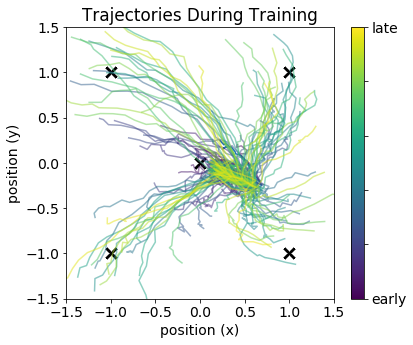

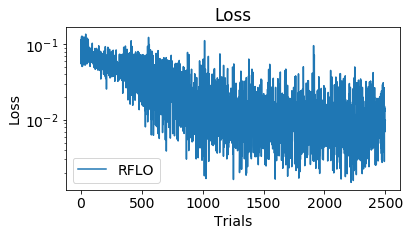

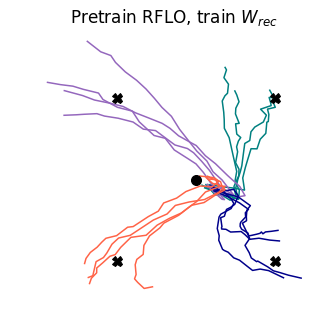

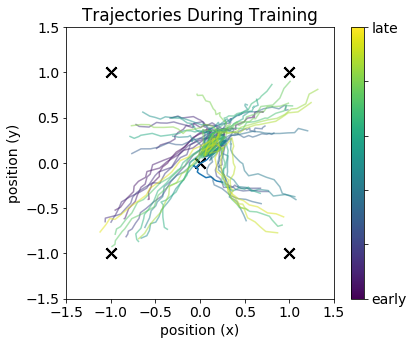

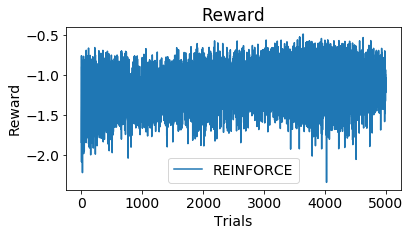

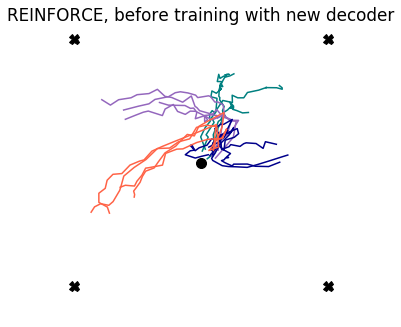

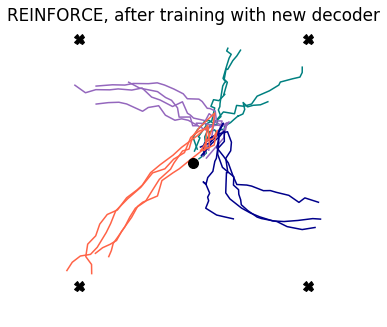

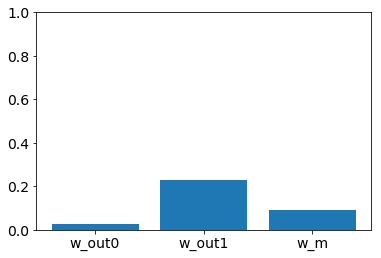

94it [00:00, 938.77it/s]

M norm: 1.10	 M angle: 0.60, 0 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.29

500it [00:00, 1068.47it/s]
5000it [00:09, 531.11it/s]
500it [00:00, 1262.64it/s]


AR early fit 0.963, late fit 0.973


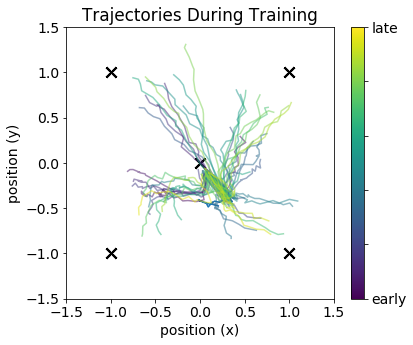

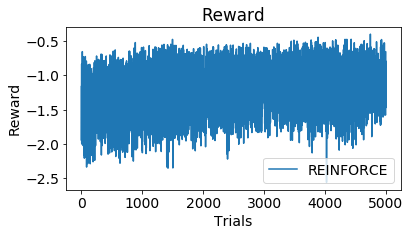

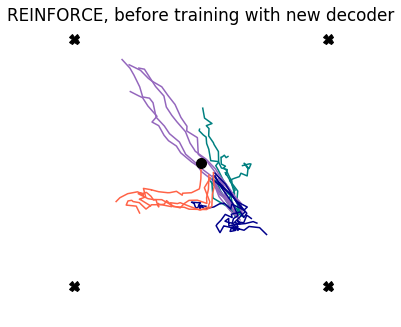

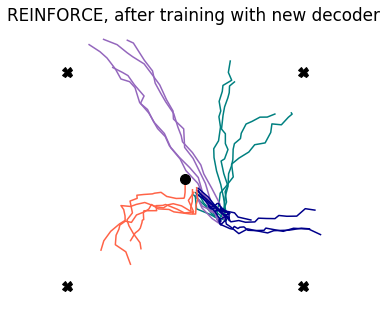

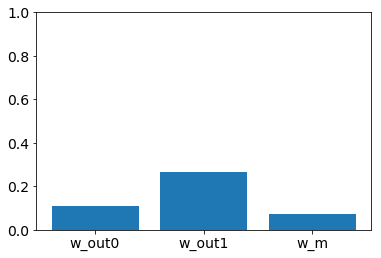

123it [00:00, 1225.49it/s]

M norm: 1.05	 M angle: 0.59, 11 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.69	 w_out vs. w_m angle: 0.29

500it [00:00, 1260.29it/s]
5000it [00:09, 546.51it/s]
500it [00:00, 1257.88it/s]


AR early fit 0.963, late fit 0.974


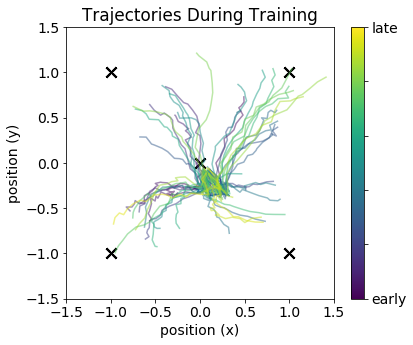

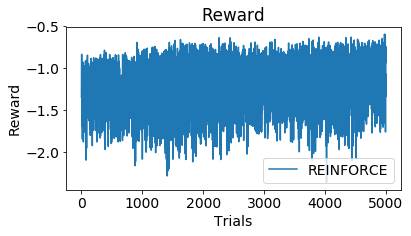

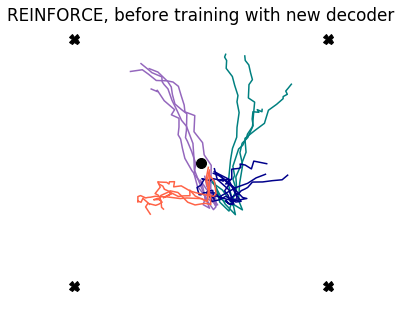

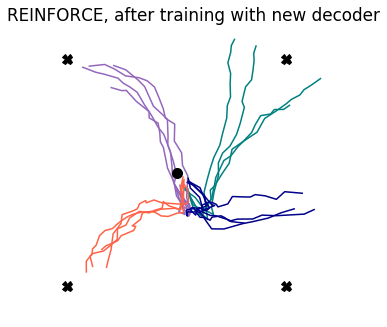

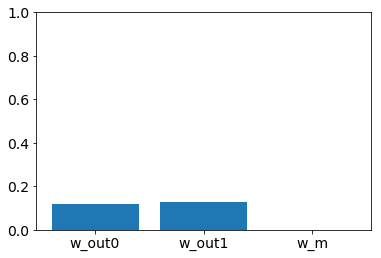

111it [00:00, 1102.17it/s]

M norm: 1.11	 M angle: 0.60, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.65	 w_out vs. w_m angle: 0.34

500it [00:00, 1204.72it/s]
5000it [00:09, 510.38it/s]
500it [00:00, 1170.13it/s]


AR early fit 0.963, late fit 0.973


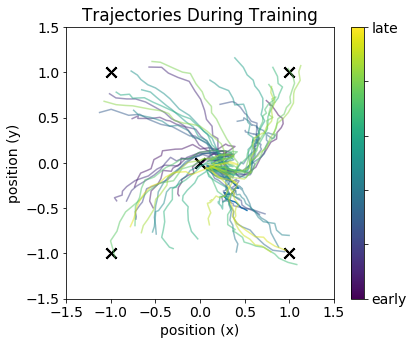

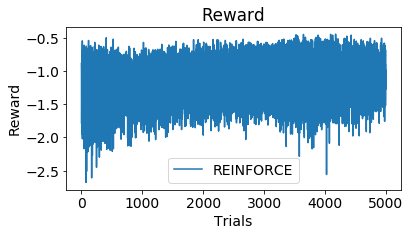

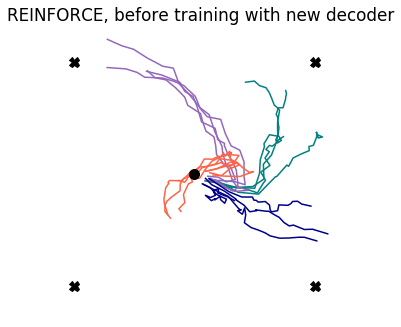

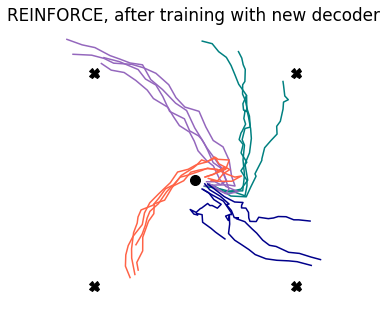

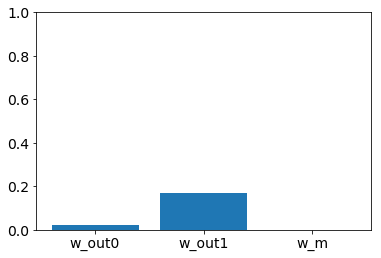

82it [00:00, 819.92it/s]

M norm: 1.12	 M angle: 0.59, 0 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.12	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.62	 w_out vs. w_m angle: 0.38

500it [00:00, 1047.37it/s]
5000it [00:09, 526.64it/s]
500it [00:00, 1208.38it/s]


AR early fit 0.963, late fit 0.974


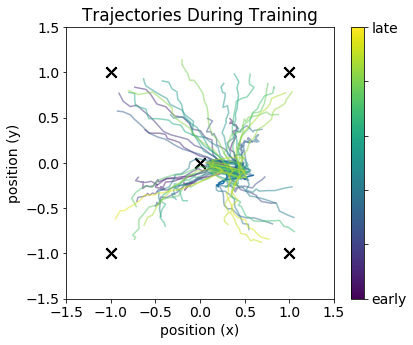

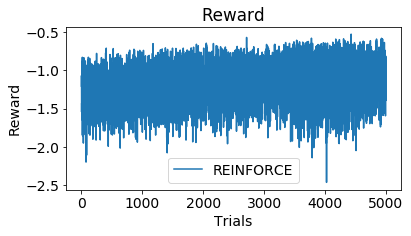

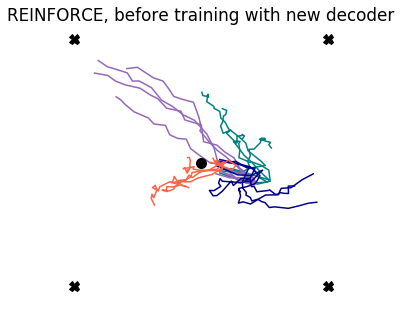

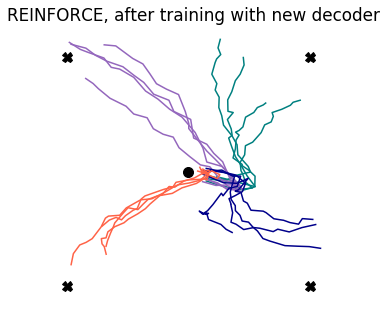

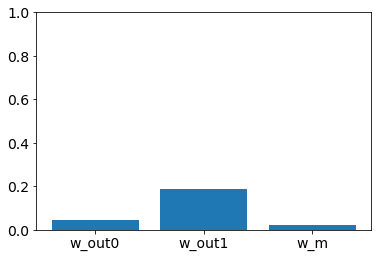

118it [00:00, 1177.80it/s]

M norm: 1.09	 M angle: 0.60, 6 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.68	 w_out vs. w_m angle: 0.31

500it [00:00, 1258.84it/s]
5000it [00:09, 538.14it/s]
500it [00:00, 1279.28it/s]


AR early fit 0.963, late fit 0.974


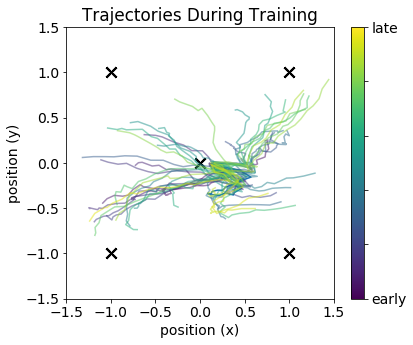

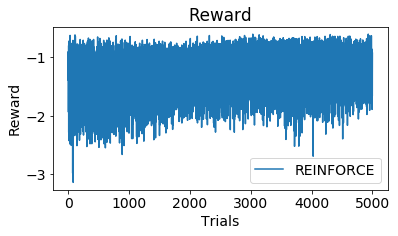

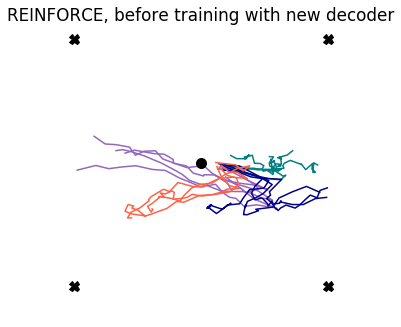

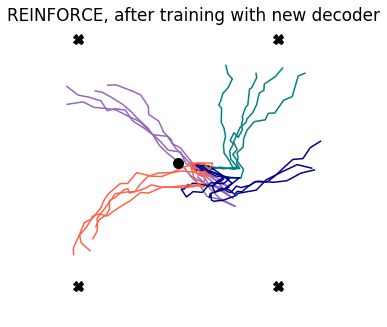

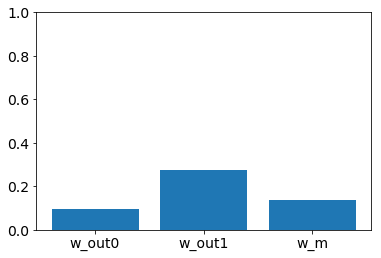

In [170]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,2,3,4,5]
overlaps = [0.6]
n_changes = [50]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net2_pre = RNN(params)
        net2_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2_pre.set_weights(w_out = w_out1)
        net2_pre.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net2 = RNN(params)
        net2.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net2.set_weights(w_out = w_out1)
        net2.set_weights(w_m = 0*w_m.T) # shouldn't matter for REINFORCE



        """ Track activity with new decoder, before training """

        sim2_pre = Simulation(net2_pre)
        trackvars = TrackVars(net2_pre,apply_to=[]) 
        sim2_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim2_train = Simulation(net2)
        reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False,tau_reward=5)
        sim2_train.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=100)

        """ Track activity with new decoder, after training """
        net2_post = RNN(params)
        net2_post.set_weights(w_in=net2.w_in.copy(), w_rec=net2.w_rec.copy())
        net2_post.set_weights(w_out = net2.w_out)
        net2_post.set_weights(w_m = 0*net2.w_m) # shouldn't matter for REINFORCE

        sim2_post = Simulation(net2_post)
        trackvars = TrackVars(net2_post,apply_to=[]) 
        sim2_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim2_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim2_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim2_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim2_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim2_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim2_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim2_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim2_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color='r',alpha=0.5)
        plt.ylim([0,1])
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)


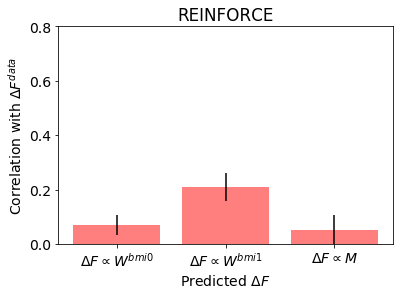

In [190]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta F \propto W^{bmi0}$',r'$\Delta F \propto W^{bmi1}$',r'$\Delta F \propto M$'],color='r',alpha=0.5)
plt.ylim([0,0.8])
plt.title('REINFORCE')
plt.ylabel('Correlation with '+r'$\Delta F^{data}$')
plt.xlabel('Predicted '+r'$\Delta F$')
plt.show()

# Repeat Analysis for BPTT Multiple Networks/Seeds

Here is where I need to establish that these results are robust. Using the same initialized, pretrained network, I calculate the correlation across 6 random choices of new decoder matrices `w_out1` and internal models `w_m`. As before, I choose a 60% overlap with the old decoder `w_out0`

21it [00:00, 202.51it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fce9383a3f0>


2500it [00:08, 284.60it/s]
102it [00:00, 1014.29it/s]

M norm: 1.06	 M angle: 0.61, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.06	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

500it [00:00, 1079.61it/s]
33it [00:00, 323.67it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 367.83it/s]
500it [00:00, 1111.98it/s]


AR early fit 0.963, late fit 0.982


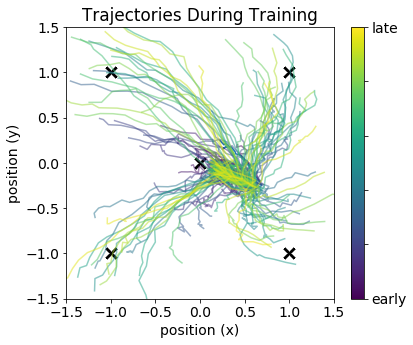

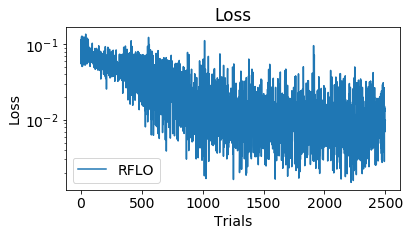

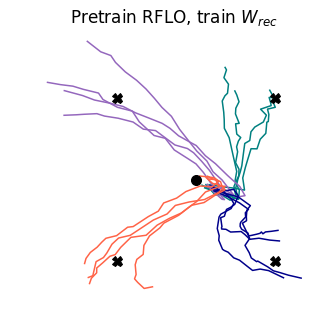

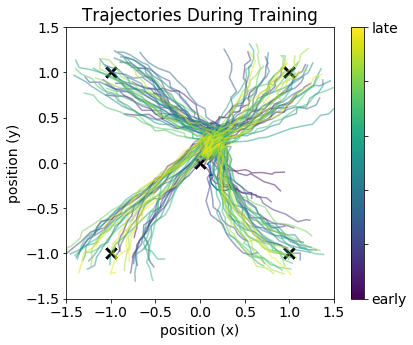

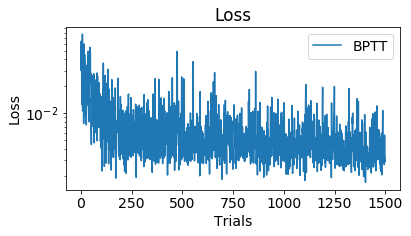

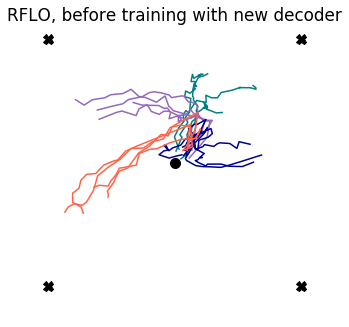

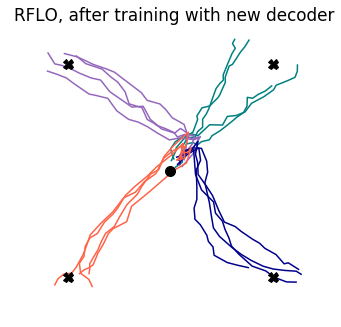

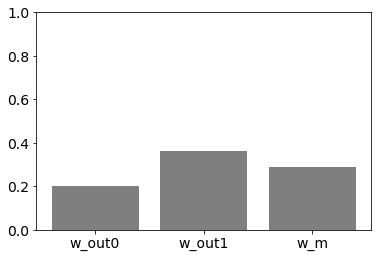

113it [00:00, 1125.90it/s]

M norm: 1.10	 M angle: 0.60, 0 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.10	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.71	 w_out vs. w_m angle: 0.29

500it [00:00, 1161.30it/s]
33it [00:00, 325.72it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 350.28it/s]
500it [00:00, 1181.02it/s]


AR early fit 0.963, late fit 0.983


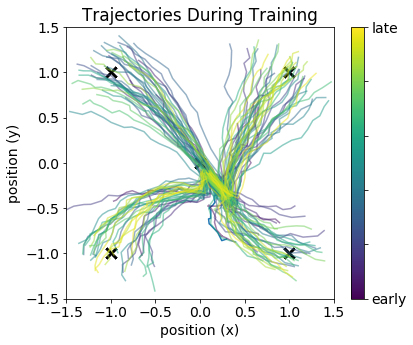

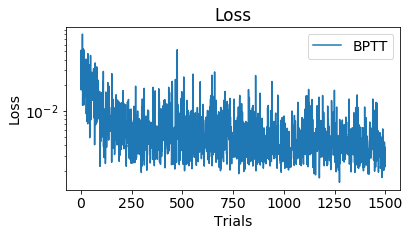

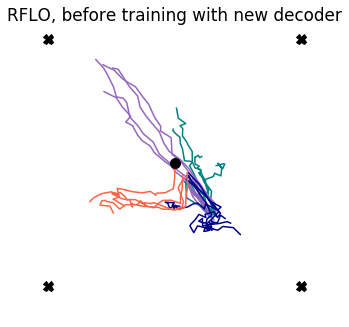

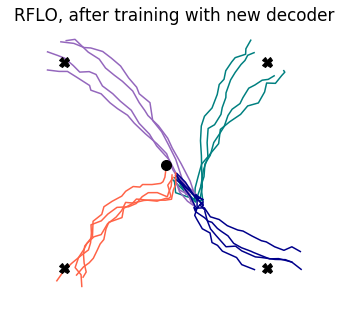

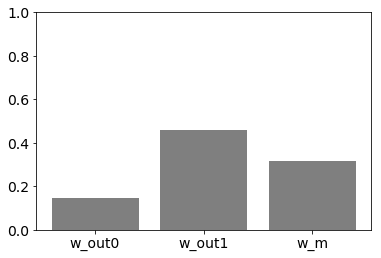

111it [00:00, 1109.39it/s]

M norm: 1.05	 M angle: 0.59, 11 iterations
w_out1 norm: 1.35	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.05	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.69	 w_out vs. w_m angle: 0.29

500it [00:00, 1170.28it/s]
33it [00:00, 329.59it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 363.20it/s]
500it [00:00, 1202.85it/s]


AR early fit 0.963, late fit 0.982


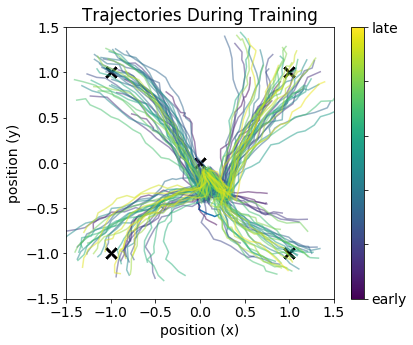

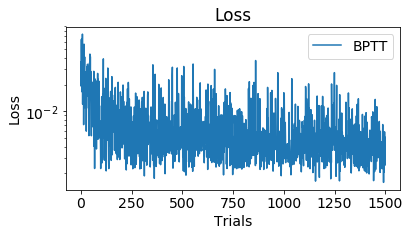

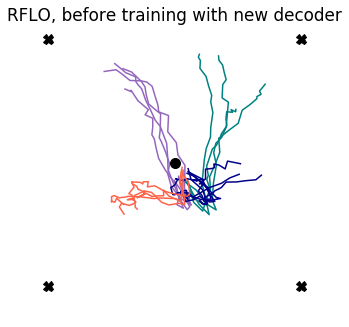

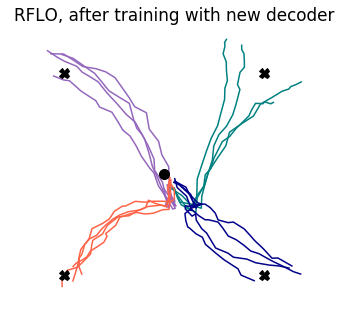

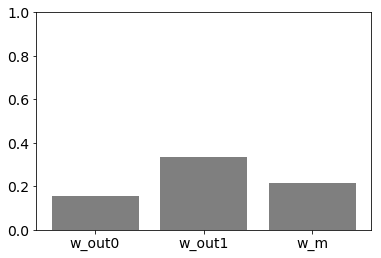

102it [00:00, 1013.85it/s]

M norm: 1.11	 M angle: 0.60, 0 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.65	 w_out vs. w_m angle: 0.34

500it [00:00, 1156.40it/s]
35it [00:00, 348.94it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 370.09it/s]
500it [00:00, 1127.90it/s]


AR early fit 0.963, late fit 0.980


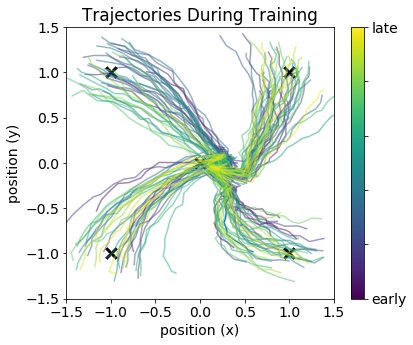

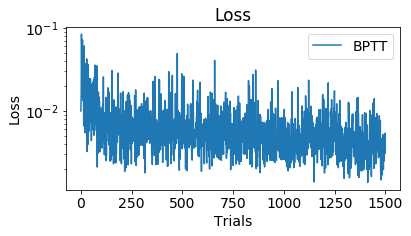

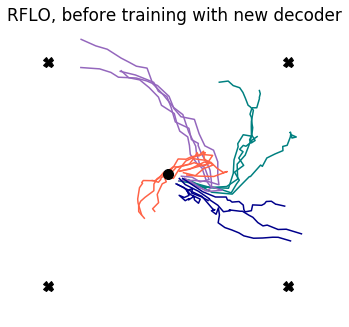

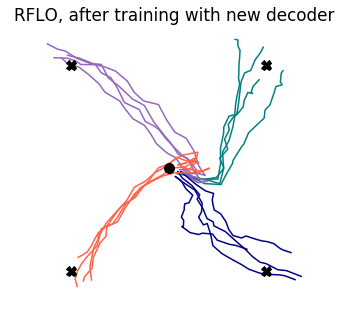

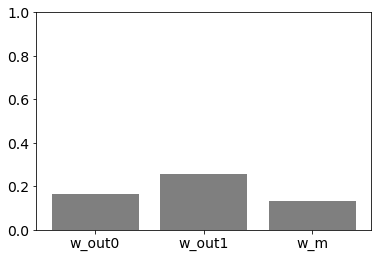

113it [00:00, 1124.30it/s]

M norm: 1.12	 M angle: 0.59, 0 iterations
w_out1 norm: 1.36	 w_out vs. w_out1 angle: 0.61
w_m norm: 1.12	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.62	 w_out vs. w_m angle: 0.38

500it [00:00, 1158.75it/s]
34it [00:00, 337.76it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:03, 393.97it/s]
500it [00:00, 1204.87it/s]


AR early fit 0.963, late fit 0.983


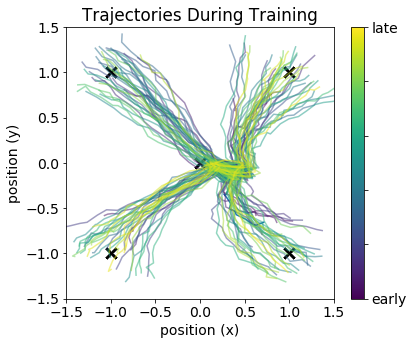

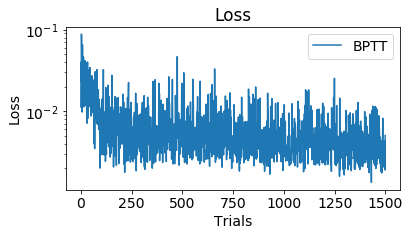

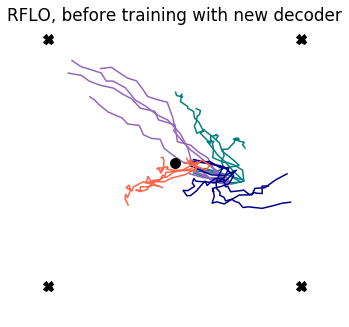

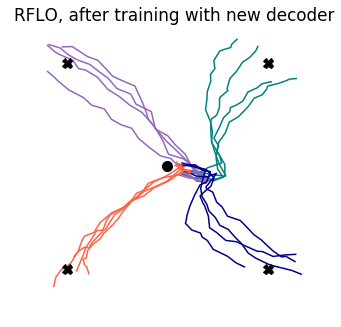

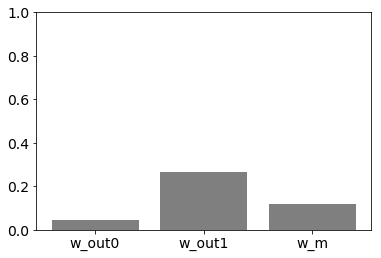

115it [00:00, 1149.29it/s]

M norm: 1.09	 M angle: 0.60, 6 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.59
w_m norm: 1.09	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.68	 w_out vs. w_m angle: 0.31

500it [00:00, 1232.50it/s]
35it [00:00, 348.61it/s]

>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 366.91it/s]
500it [00:00, 1197.60it/s]


AR early fit 0.963, late fit 0.983


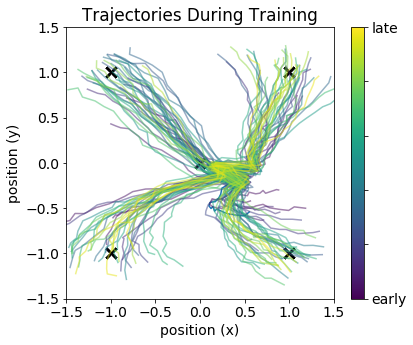

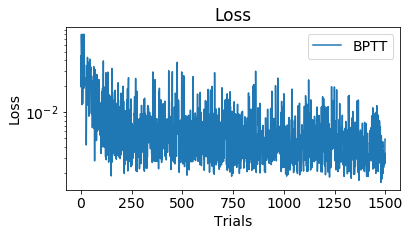

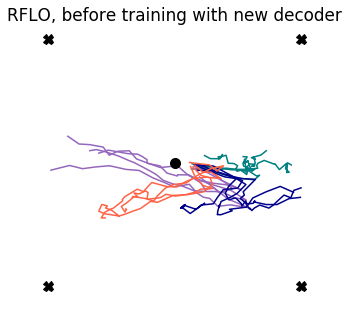

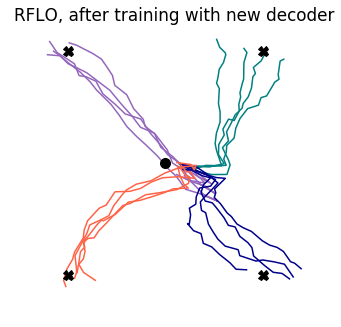

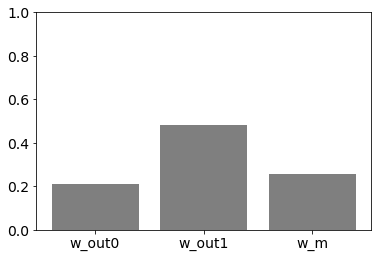

In [17]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,1,2,3,4,5]
overlaps = [0.6]
n_changes = [50]

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_out1.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_out1.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        bptt = BPTT(net1,apply_to=['w_rec'],weight_transport=True)
        sim1_train.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='BPTT, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='BPTT, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color='k',alpha=0.5)
        plt.ylim([0,1])
        plt.show()
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)


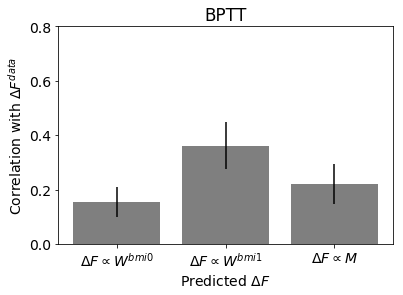

In [18]:
""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta F \propto W^{bmi0}$',r'$\Delta F \propto W^{bmi1}$',r'$\Delta F \propto M$'],color='k',alpha=0.5)
plt.ylim([0,0.8])
plt.title('BPTT')
plt.ylabel('Correlation with '+r'$\Delta F^{data}$')
plt.xlabel('Predicted '+r'$\Delta F$')
plt.show()